# Transfomer 기반 Global 모델

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import math
from itertools import chain
from typing import List, Tuple, Optional, Any
from typing import Dict, Literal
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

from models.Transformer import TimeSeriesTransformer
from models.Informer import Informer
from models.Autoformer import Autoformer
from models.FEDformer import FEDformer
from models.PatchTST import PatchTST

from utils.train import train_model
from utils.test import test_model
from plots.plot import plot_forecast
from utils.metrics import mae, rmse, mape

from torch.nn.utils import clip_grad_norm_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load and Preprocess Data

데이터 불러오기

1. 모든 Bobcat 지역의 측정값 데이터를 불러와 하나의 DF 생성

In [2]:
def filter_Bobcat_and_rename(df, suffix):
    """
    Function: filter_Bobcat_and_rename
        1. Bobcat 지역 건물들만 추출
        2. 컬럼명 rename (건물명_측정값 -> 측정값_suffix)
    Parameters:
        - df: 각 측정값 df
        - suffix: 측정값 종류 (예: electricity, water, gas)
    Returns:
        - out: Bobcat 지역 건물들만 추출 & 컬럼명 rename 된 df
    """
    # timestamp 열(공통) 항상 유지
    keep_col = ['timestamp']

    # Bobcat 지역 건물들만 추출
    for col in df.columns:
        if col == 'timestamp': # timestamp 열은 이미 추가했으므로 건너뜀
            continue
        first_token = col.split('_', 1)[0] # 지역명 추출
        if first_token == 'Bobcat': # 지역명 = 'Bobcat'
            keep_col.append(col) # 유지할 컬럼 리스트에 추가
    # Bobcat 지역 건물들만 추출
    out = df[keep_col].copy()

    # 컬럼명 rename
    rename_map = {}
    for col in out.columns:
        # 지역명_건물특성_건물명 -> 건물명_측정값 형태로 rename
        if col != 'timestamp':
            parts = col.split('_', 2) # 건물명 추출
            if len(parts) == 3:
                # 건물명_측정값 형태로 rename
                new_name = f"{parts[2]}_{suffix}" 
                rename_map[col] = new_name
    out = out.rename(columns=rename_map)
    out = pd.DataFrame(out) 
    return out # Bobcat 지역 건물들만 추출 & 컬럼명 rename 된 df

In [3]:
def load_and_prepare_data(file, parse_dates=['timestamp'], sep=','):
    """
    Function: load_and_prepare_data
        1. 데이터 파일 불러오기
        2. Bobcat 지역 건물들만 추출 & 컬럼명 rename
        3. 모든 측정값 df를 timestamp 기준으로 outer-merge
    Parameters:
        - file: {측정값 종류: 파일 경로} 딕셔너리
        - parse_dates: 날짜로 파싱할 열 리스트 (기본값: ['timestamp'])
        - sep: 구분자 (기본값: ',')
    Returns:
        - master: 모든 측정값이 결합된 마스터 df (timestamp 기준 정렬)
    """
    dfs = [] # 각 측정값 df 담을 리스트
    allbase_name = set() # 모든 건물명을 담을 집합

    # 측정값 df 하나씩 불러오기(.txt 형식임)
    for mol, path in file.items():
        df = pd.read_csv(path, parse_dates=parse_dates, sep=sep)
        df = df.sort_values('timestamp')

        # Bobcat 필터 + 이름_suffix로 rename
        df_bob = filter_Bobcat_and_rename(df, suffix=mol)
        dfs.append(df_bob) # 리스트에 추가

    # timestamp를 기준으로 outer-merge로 모두 결합
    master = dfs[0] # 첫 번째 df로 초기화
    for i in range(1, len(dfs)): # 두 번째 df부터 순차적으로 merge
        master = pd.merge(master, dfs[i], on='timestamp', how='outer')

    # timestamp 기준 정렬 및 인덱스 재설정
    master = master.sort_values('timestamp').reset_index(drop=True)

    # 열 순서 정리: timestamp먼저, 나머지는 이름순
    non_ts_cols = [col for col in master.columns if col != 'timestamp']
    master = master[['timestamp'] + sorted(non_ts_cols)]
    master = master[master['timestamp'] >= '2016-06-01 00:00:00'] # 2016-06-01 이후 데이터만
    master = master.sort_values('timestamp').reset_index(drop=True)
    master = pd.DataFrame(master)
    return master # timestamp 기준 정렬 (건물 섞인 형태)

In [4]:
files = {
    "chw": "data/chilledwater.txt",
    "elec": "data/electricity.txt",
    "hw": "data/hotwater.txt",
    "gas": "data/gas.txt",
    "irr": "data/irrigation.txt",
    "solar": "data/solar.txt",
    "stm": "data/steam.txt",
    "water": "data/water.txt"
}

df = load_and_prepare_data(files, parse_dates=['timestamp'], sep=',')

In [5]:
df

,timestamp,Adam_chw,Adam_elec,Adam_water,Alissa_chw,Alissa_elec,Alissa_gas,Alissa_hw,Alissa_solar,Alissa_water,...,Timothy_elec,Timothy_solar,Timothy_water,Toni_chw,Toni_elec,Toni_hw,Toni_water,Whitney_chw,Whitney_elec,Whitney_water
0,2016-06-01 00:00:00,0.0000,50.5000,34341.2395,0.8685,43.2500,242.7530,0.0000,0.0000,NaN,...,14.8100,0.02,0.0,0.0000,16.37,2.0996,0.0000,0.0,164.0000,1854.8509
1,2016-06-01 01:00:00,0.2577,51.5000,35068.0382,0.8575,44.7500,248.3984,0.0000,0.0000,NaN,...,15.3800,0.00,0.0,0.0000,16.38,2.0996,0.0000,0.0,190.0000,1816.9968
2,2016-06-01 02:00:00,0.0000,50.3800,35128.6048,0.8575,44.5000,429.0518,0.0000,0.0000,NaN,...,17.5600,0.02,0.0,0.0000,16.62,1.0498,37.8541,0.0,177.0000,1854.8509
3,2016-06-01 03:00:00,0.0000,51.2500,35249.7379,0.8575,45.0000,412.1155,0.0000,0.0000,NaN,...,16.7500,0.00,0.0,0.0000,16.88,1.3997,0.0000,0.0,174.0000,1816.9968
4,2016-06-01 04:00:00,0.0000,51.2500,35613.1373,1.7150,44.0000,570.1872,0.0000,0.0000,NaN,...,20.5300,0.02,0.0,0.0000,16.12,1.7496,0.0000,0.0,173.0000,1816.9968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13891,2017-12-31 19:00:00,NaN,68.1301,NaN,0.0000,42.7500,4.5778,0.0000,131.0708,NaN,...,28.3700,0.01,0.0,0.0000,20.75,5.5988,37.8541,NaN,146.0002,1476.3122
13892,2017-12-31 20:00:00,NaN,78.7499,NaN,0.0000,51.7500,4.5778,29.3078,131.0752,NaN,...,31.0700,0.02,0.0,0.0000,24.00,4.8990,0.0000,NaN,170.0000,1779.1419
13893,2017-12-31 21:00:00,NaN,71.0002,NaN,0.0000,41.2501,4.5778,29.3086,131.0676,NaN,...,30.2501,0.01,0.0,0.0000,22.38,4.8990,0.0000,NaN,156.0002,1589.8730
13894,2017-12-31 22:00:00,NaN,74.2502,NaN,0.0000,41.0000,4.5778,29.3059,131.0698,NaN,...,33.1200,0.02,0.0,0.0001,22.62,4.8989,0.0000,NaN,157.0002,1589.8726


2. 데이터를 각 건물 당 시계열 데이터로 형태 변경
    - long 포맷 데이터
    - 가장 base 형태의 시계열 데이터

In [6]:
def transform_to_long_format(df):
    """
    Function: transform_to_long_format
        1. 앞서 만든 data (a_elec, a_chw, b_elec, ... 형태)를 long 포맷으로 변환
            - long 포맷: (timestamp, building_name, elec, chw, ...). 건물 별 시계열 데이터
            - 해당 건물에 특정 측정값이 없으면 concat 시 NaN 처리됨
        2. 이후 비시계열 특성(meta)와 공통 시계열 데이터와 결합 하여 모델 입력 베이스로 사용할 예정
    Parameters:
        - df: 넓은 형태의 건물별 측정치 컬럼 (a_elec, a_chw, b_elec, ...)
    Returns:
        - long_df: (timestamp, building_name, elec, chw, ...) 형태의 long 포맷 df
    """
    # 원본 훼손 방지
    df = df.copy()

    # timestamp를 인덱스로 설정
    df = df.set_index("timestamp")

    # 가능한 측정치 이름(있으면 사용, 없으면 스킵)
    metric_names = ["elec", "chw", "hw", "gas", "irr", "solar", "stm", "water"]

    # 건물 접두사 추출
    # '_'가 있고, 뒤쪽 토큰이 측정값 목록 중 하나인 컬럼만 대상으로 함
    building_prefixes = set()
    for c in df.columns:
        if "_" in c:
            prefix, suffix = c.split("_", 1) # 건물명. 좌: 건물명, 우: 측정치
            if suffix in metric_names:
                building_prefixes.add(prefix)

    # 결과를 담을 리스트
    reshaped_list = []

    # 건물별로 long 포맷으로 변환
    for prefix in sorted(building_prefixes): # 건물 명 알파벳 순으로 정렬
        # 해당 건물의 측정치 컬럼들만 추출 (a_elec, a_chw, ...)
        building_cols = [f"{prefix}_{m}" for m in metric_names if f"{prefix}_{m}" in df.columns]

        # 해당 건물에 측정치가 하나도 없으면 스킵
        if not building_cols: 
            continue

        # 건물 부분 데이터프레임 복사
        temp = df[building_cols].copy()
        # 접두사 제거 (a_elec -> elec)
        temp = temp.rename(columns=lambda x: x.replace(prefix + "_", ""))
        # 건물명 컬럼 추가
        temp["building_name"] = prefix
        # timestamp를 인덱스에서 열로 복원
        temp["timestamp"] = temp.index
        # 결과 리스트에 추가
        reshaped_list.append(temp)

    # reshaped_list를 하나의 데이터프레임으로 결합
    long_df = pd.concat(reshaped_list, axis=0, ignore_index=True)

    # 열 순서 정리: timestamp, building_name, 나머지 측정치들
    ordered_cols = ["timestamp", "building_name"] + [c for c in metric_names if c in long_df.columns]
    long_df = long_df[ordered_cols]
    # 건물명 및 timestamp 기준 정렬
    long_df = long_df.sort_values(["building_name", "timestamp"]).reset_index(drop=True)
    # 중복된 (building_name, timestamp) 행 제거 (있으면 첫 번째 행 유지)
    long_df = long_df.drop_duplicates(subset=["building_name", "timestamp"], keep="first")
    # 최종 인덱스를 timestamp로 설정
    long_df = long_df.set_index("timestamp")

    return long_df # (timestamp, building_name, elec, chw, ...) 형태의 long 포맷 df

In [7]:
long_df = transform_to_long_format(df)

In [8]:
long_df.columns

Index(['building_name', 'elec', 'chw', 'hw', 'gas', 'solar', 'water'], dtype='object')

In [9]:
# long_df.to_csv("data/long_format_bobcat_buildings.csv", index=False)

3. metadata 불러오기
    - 건물의 특성 정보 불러오기
    - 시계열 데이터가 아닌 각 건물마다의 정보를 포함하고 있음 (행: 건물명)
    - 추후, 모델 학습 직전에 합칠 예정

In [10]:
# metadata 불러오기
meta = pd.read_csv("data/metadata.txt", sep=",")

# site_id == Bobcat 인 것만 추출
meta = meta[meta["site_id"] == "Bobcat"]

# 필요없는 열 제거
meta = meta.drop(columns=[
    'site_id', 'building_id_kaggle', 'site_id_kaggle','sub_primaryspaceusage', 
    'lat', 'lng', 'timezone', 'electricity', 'hotwater', 'chilledwater', 'steam',
    'water', 'irrigation', 'solar', 'gas', 'industry', 'subindustry', 'occupants'
])

# 전체 행이 NaN인 열 제거
meta = meta.dropna(axis=1, how='all')

# building_id를 두 번째 _이후 문자열로 변경
def extract_building_id(full_name):
    parts = full_name.split('_', 2)
    if len(parts) == 3:
        return parts[2]
    return full_name

meta['building_id'] = meta['building_id'].apply(extract_building_id)
# building_id를 building_name으로 변경 (이후 long_df와 조인할 때 사용)
meta['building_name'] = meta['building_id']
# building_name을 가장 앞 열로 이동
cols = meta.columns.tolist()
cols.insert(0, cols.pop(cols.index('building_name')))
meta = meta[cols]
# building_id 열 제거 (building_name과 중복되므로)  
meta = meta.drop(columns=['building_id'])
# 건물명 알파벳 순으로 정렬
meta = meta.sort_values('building_name')
meta = meta.reset_index(drop=True)

In [11]:
# meta["building_name"]를 long_df["building_name"] 기준으로 필터링
meta = meta[meta["building_name"].isin(long_df["building_name"].unique())].reset_index(drop=True)

In [12]:
meta

,building_name,primaryspaceusage,sqm,sqft,numberoffloors
0,Adam,Entertainment/public assembly,2053.2,22101.0,2.0
1,Alissa,Education,11254.8,121146.0,2.0
2,Alma,Office,1060.9,11419.0,1.0
3,Angela,Education,8802.7,94751.0,3.0
4,Angie,Public services,14777.3,159062.0,2.0
5,Barbra,Education,2538.0,27319.0,2.0
6,Billy,Entertainment/public assembly,19859.1,213762.0,2.0
7,Camilla,Entertainment/public assembly,3696.4,39788.0,5.0
8,Charlie,Warehouse/storage,2213.2,23823.0,1.0
9,Coleman,Education,10551.9,113580.0,2.0


In [13]:
# meta.to_csv("data/metadata_bobcat_buildings.csv", index=False)

4. 공통 data 불러오기
- weather
    - airTemperature: 대기 기온(°C)
    - cloudCoverage: 구름 양(0~100, % 단위)
    - dewTemperature: 이슬점 온도(°C)
    - precipDepth1HR: 직전 1시간 강수량(mm)
    - precipDepth6HR: 직전 6시간 강수량(mm)
    - seaLvlPressure: 해면기압(hPa)
    - windDirection: 풍향(도, 0°=북쪽)
    - windSpeed: 풍속(m/s)

- Date/Time

- 시계열 데이터이나, Bobcat 지역의 건물들은 모두 동일한 값을 가지므로 분리함
- 추후, 모델 학습 직전에 합칠 예정

날씨 데이터

In [14]:
# 날씨 데이터 불러오기
weather = pd.read_csv("data/weather.txt", parse_dates=['timestamp'], sep=",")

# Bobcat 필터링
weather = weather[weather['site_id'] == 'Bobcat']

# 2016-06-01 이후 데이터만 사용
weather = weather[weather['timestamp'] >= '2016-06-01 00:00:00']
# 필요없는 열 제거
weather = weather.drop(columns=['site_id', 'precipDepth6HR'])
# timestamp 중복 제거 및 정렬
weather = weather.sort_values('timestamp').reset_index(drop=True).drop_duplicates(subset=["timestamp"], keep="first")
# 인덱스를 timestamp로 설정
weather = weather.set_index(weather['timestamp']).drop(columns=['timestamp'])

날짜 데이터

In [15]:
# 날짜 데이터 불러오기
date = pd.read_csv("data/electricity.txt", parse_dates=['timestamp'], sep=",")
date = date.sort_values("timestamp").drop_duplicates(subset=["timestamp"], keep="first")

cols = ['timestamp', 'Bobcat_education_Alissa']
date = date.loc[:, cols]

date = date[date['timestamp'] >= '2016-06-01 00:00:00']

# 요일 인코딩 (0: 월요일, 6: 일요일)
# date["Date/Time"] = pd.to_datetime(date.index)
date["dayofweek"] = date["timestamp"].dt.dayofweek

date["dow_sin"] = np.sin(2 * np.pi * date["dayofweek"] / 7)
date["dow_cos"] = np.cos(2 * np.pi * date["dayofweek"] / 7)

# 주말/공휴일 인코딩
# 주말
date["is_weekend"] = date["dayofweek"].isin([5, 6]).astype(int)

# 공휴일 인코딩 (해당 지역의 정확한 위치가 없어 공휴일 제외)

# 시간대 인코딩
date["hour"] = date["timestamp"].dt.hour
date["hour_sin"] = np.sin(2 * np.pi * date["hour"] / 24)
date["hour_cos"] = np.cos(2 * np.pi * date["hour"] / 24)

date = date.drop(columns=['Bobcat_education_Alissa', 'dayofweek', 'hour'])
date = date.set_index(date['timestamp']).drop(columns=['timestamp'])

공통 데이터 생성하기

In [16]:
common = weather.join(date, how="outer")

In [17]:
# common.to_csv("data/common_bobcat_buildings.csv", index=True) # weather + date

## 모델 EDA

- 데이터 프레임
    - long_df: 각 건물들의 측정값을 담은 long 포맷 데이터 (시계열 데이터)
    - meta: 건물들의 특성 정보
    - common: 공통되는 데이터(weather + date/time, 시계열 데이터)

측정값 별 시각화 (long_df)

In [18]:
long_df.columns

Index(['building_name', 'elec', 'chw', 'hw', 'gas', 'solar', 'water'], dtype='object')

In [19]:
def plot_buildings_matrix(df, metric="elec", aliases=None, reindex_hourly=False):
    """
    Function: plot_buildings_matrix
        - df에서 metric(측정값)별로 건물 시계열을 추출하여 서브플롯 행렬로 시각화
    Parameters:
        - df: (timestamp, building_name, elec, chw, ...) 형태의 long 포맷 df
        - metric: 시각화할 측정값 (기본값: "elec")
        - aliases: 측정값 접미사 별칭 딕셔너리 (기본값: None)
            예: {"elec": ["elec", "elc"], "chw": ["chw", "chilledwater"]}
        - reindex_hourly: True면 1시간 간격으로 재인덱싱 (기본값: False)
    Returns:
        - None (시각화만 수행)
    """
    # 기본 접미사 딕셔너리
    default_aliases = {
        "elec": ["elec", "electricity"],
        "chw": ["chw", "chilledwater"],
        "hw": ["hw", "hotwater"],
        "gas": ["gas"],
        "steam": ["steam"],
        "water": ["water"],
        "solar": ["solar"],
    }
    # 사용자 별칭 병합
    if aliases is not None:
        for k, v in aliases.items():
            default_aliases[k] = v

    # 시리즈 접미사 전체 집합 (건물 후보 추출 시 사용)
    allowed_suffixes = set(chain.from_iterable(default_aliases.values()))

    # 선택 metric의 접미사 리스트
    metric_suffixes = default_aliases.get(metric, [metric])

    # 건물 prefix 추출: "prefix_suffix" 형태이면서 suffix가 허용 목록에 있는 컬럼만 인정
    building_prefixes = set()
    for c in df.columns:
        if "_" not in c:
            continue  # 언더스코어 없는 열은 건물_측정값 형식 아님
        prefix, suffix = c.split("_", 1)
        if suffix in allowed_suffixes:
            building_prefixes.add(prefix)

    # metric 보유 여부 확인
    no_metric_buildings = []
    series_by_building = {}

    for b in sorted(building_prefixes):
        # 후보 컬럼명 (예: b_elec, b_elc)
        candidates = [f"{b}_{sfx}" for sfx in metric_suffixes]
        col = next((c for c in candidates if c in df.columns), None)

        if col is None:
            # metric 컬럼이 없는 건물만 기록 (timestamp 같은 일반 열은 애초 후보에 포함 X)
            no_metric_buildings.append(b)
        else:
            # 해당 건물의 metric 시계열만 추출
            tmp = df[[col]].rename(columns={col: metric}).copy()
            # 필요 시 1시간 간격 재인덱싱
            if reindex_hourly and len(tmp) > 0:
                full_index = pd.date_range(start=tmp.index.min(),
                                           end=tmp.index.max(),
                                           freq="H")
                tmp = tmp.reindex(full_index)
            series_by_building[b] = tmp

    # metric 없는 건물 이름만 출력 (timestamp 같은 일반 열은 X)
    if no_metric_buildings:
        print(f"'{metric}' 데이터 없는 건물:", ", ".join(no_metric_buildings))

    # 그릴 대상 없으면 종료
    n_buildings = len(series_by_building)
    if n_buildings == 0:
        print(f"'{metric}' 데이터가 있는 건물이 없음.")
        return

    # subplot 행렬 크기 계산
    ncols = math.ceil(math.sqrt(n_buildings))
    nrows = math.ceil(n_buildings / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)

    # axes 평탄화
    if n_buildings == 1:
        axes = [axes]
    else:
        axes = axes.ravel()

    # 건물별 그리기
    for idx, (b, data_b) in enumerate(series_by_building.items()):
        ax = axes[idx]
        ax.plot(data_b.index, data_b[metric], label=f"{b} {metric}")
        ax.set_title(f"Building: {b}")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel(metric)
        ax.grid(True, alpha=0.3)
        ax.legend()

    # 남는 subplot 삭제
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

electricity

'elec' 데이터 없는 건물: Rafael


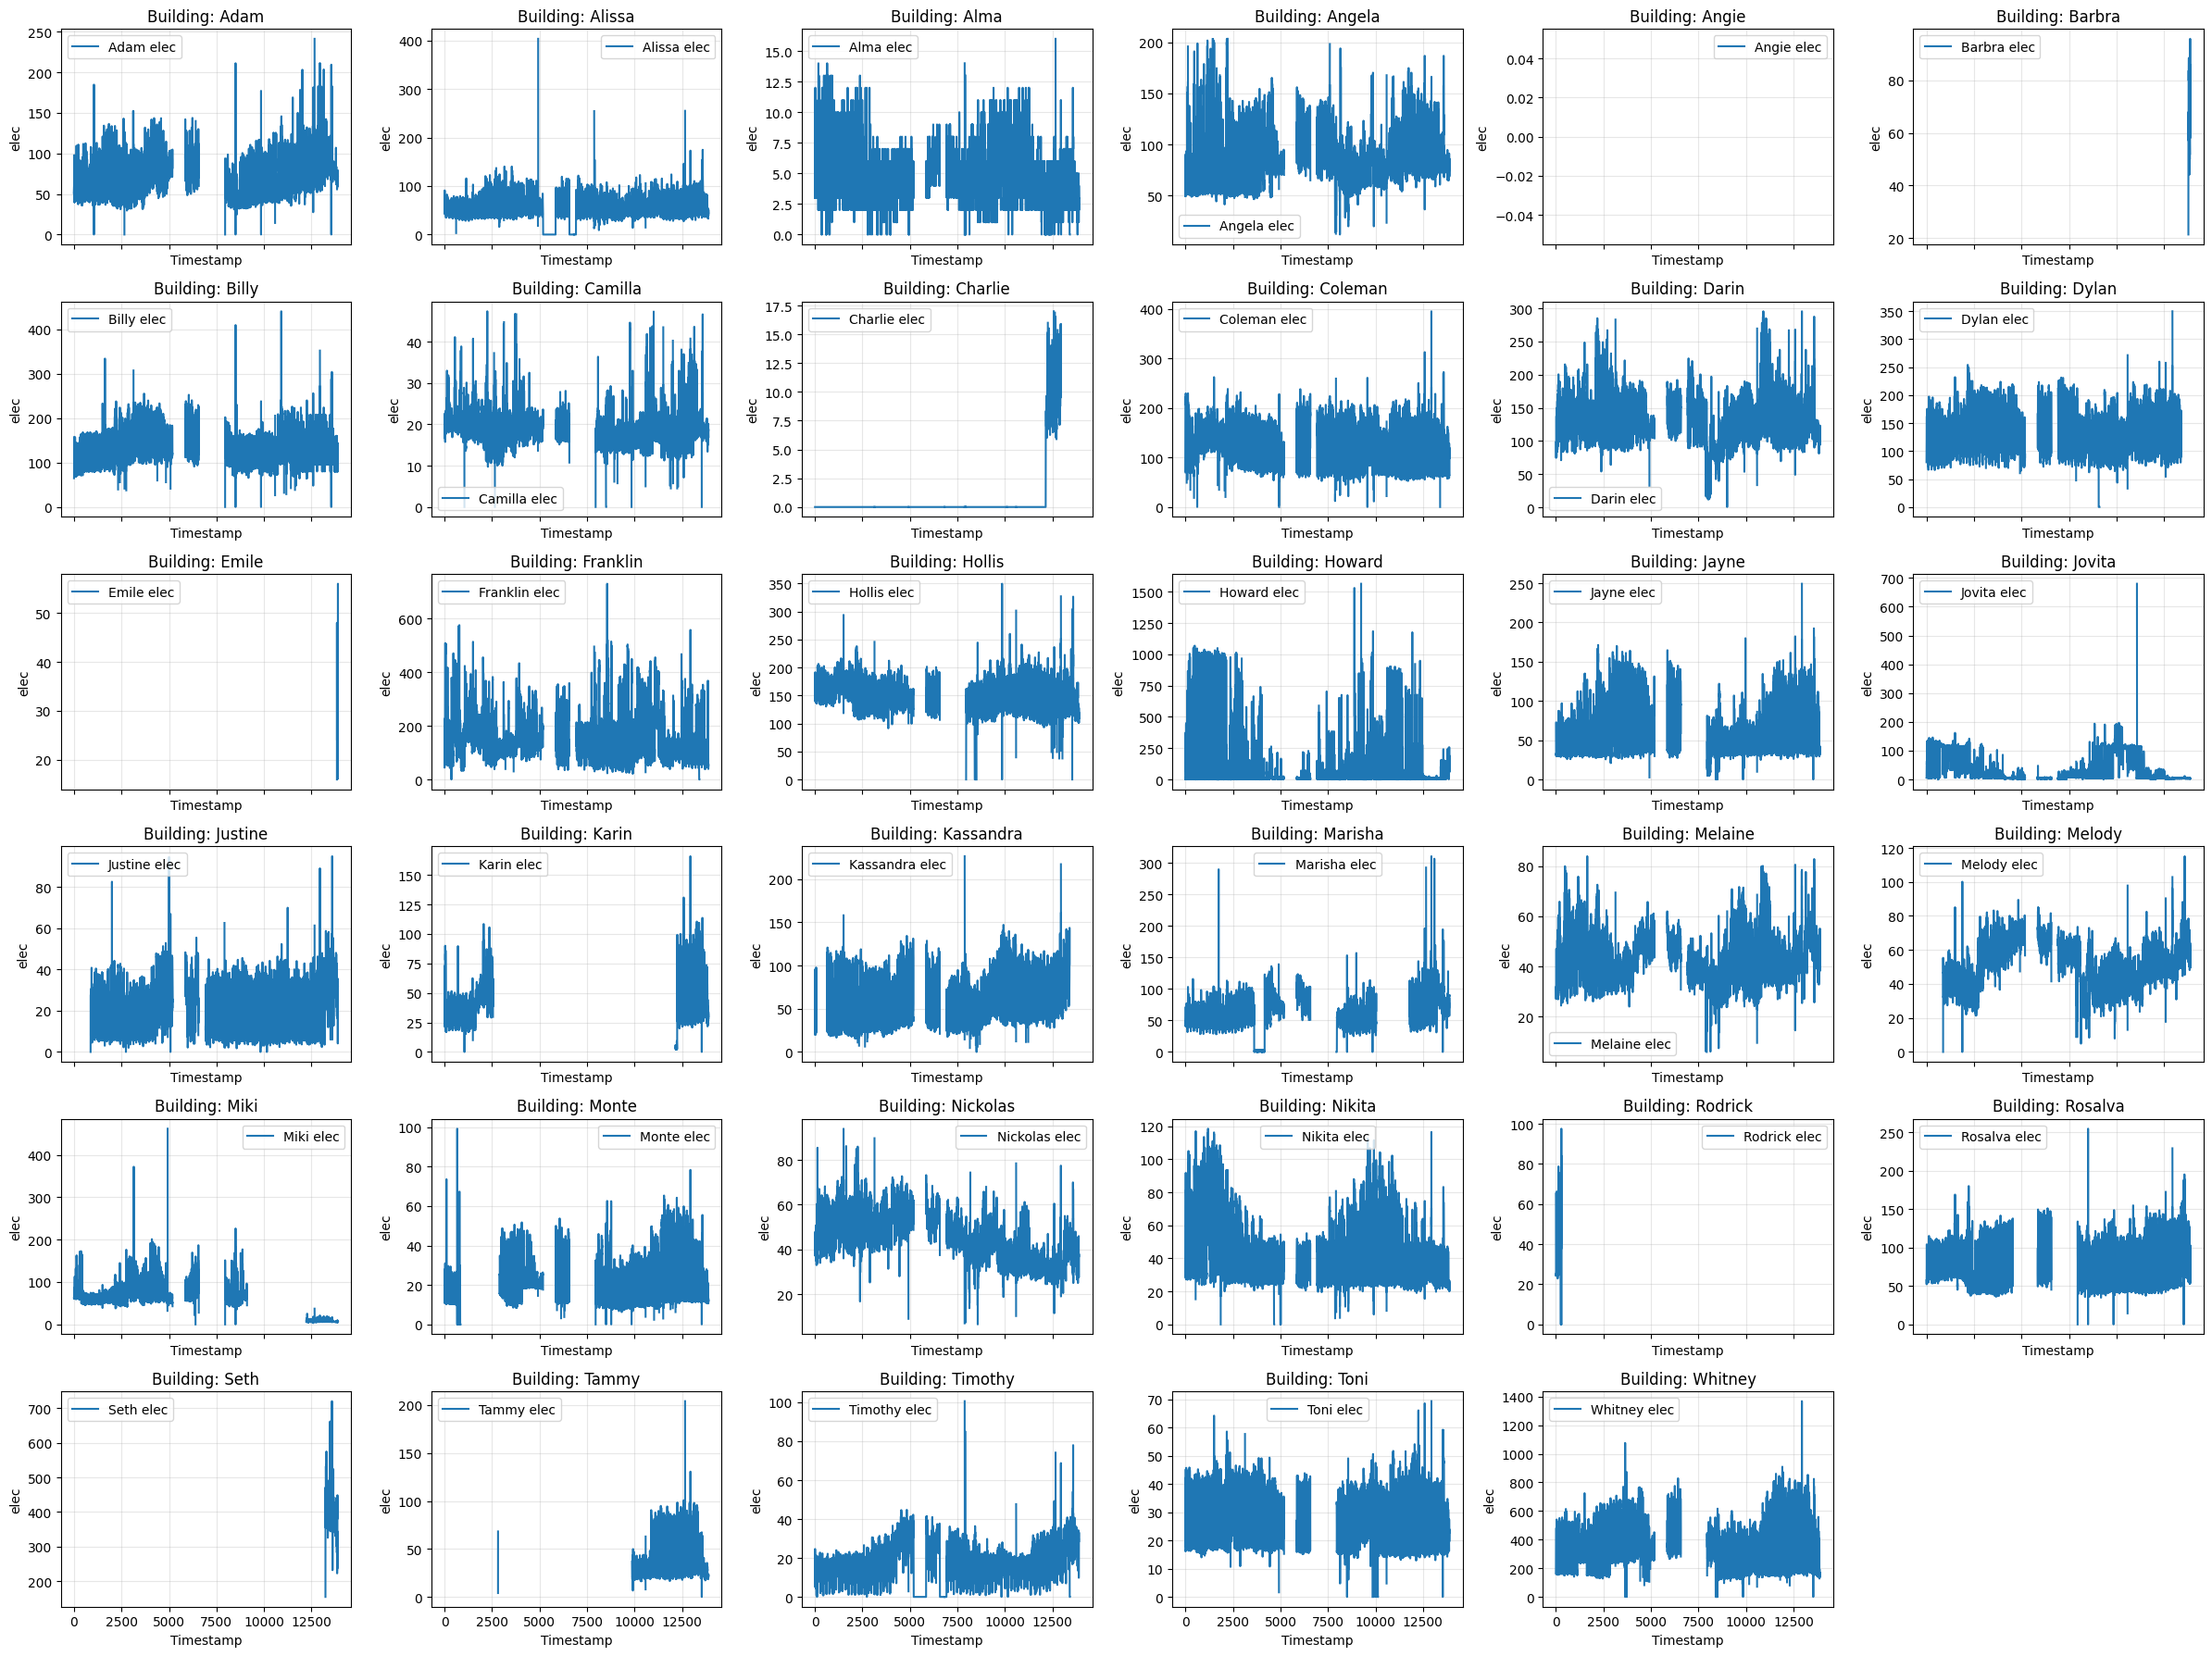

In [20]:
plot_buildings_matrix(df, metric="elec")

In [21]:
data_for_plot = df.copy() # 전처리를 위해서

In [22]:
# elec 데이터 더러운 열 제거
# building: Angie, Barbra, Charlie, Emile, Rodrick, Seth, Rafael
long_df = long_df[~long_df['building_name'].isin(
    ['Angie', 'Barbra', 'Charlie', 'Emile', 'Rodrick', 'Seth', 'Rafael'])]

# data_for_plot 열: buildingname_측정값 형태
# 특정 buildingname을 가지는 buildingname_측정값 열 모두 제거
import re
remove_buildings = ['Angie', 'Barbra', 'Charlie', 'Emile', 'Rodrick', 'Seth', 'Rafael']
pattern = r'^(?:' + '|'.join(map(re.escape, remove_buildings)) + r')_'   # 시작이 이름_ 인 열

data_for_plot = data_for_plot.loc[:, ~data_for_plot.columns.astype(str).str.contains(pattern, na=False)]

In [23]:
# 한 건물 전체가 창 생성 개수가 너무 적으면(예: < 100 윈도) 제외 검토
# Karin, Tammy, Miki
# 다른 측정값의 경우 해당 건물의 다른 데이터 확인 후 
# 해당 측정값만 drop할지, 건물 전체를 drop할지 결정 필요
# 결론: 다른 데이터도 Nan, 혹은 이상, 결측치 다수 -> drop 결정
long_df = long_df[~long_df['building_name'].isin(
    ['Karin', 'Tammy', 'Miki'])]
long_df

remove_buildings = ['Karin', 'Tammy', 'Miki']
pattern = r'^(?:' + '|'.join(map(re.escape, remove_buildings)) + r')_'   # 시작이 이름_ 인 열

data_for_plot = data_for_plot.loc[:, ~data_for_plot.columns.astype(str).str.contains(pattern, na=False)]

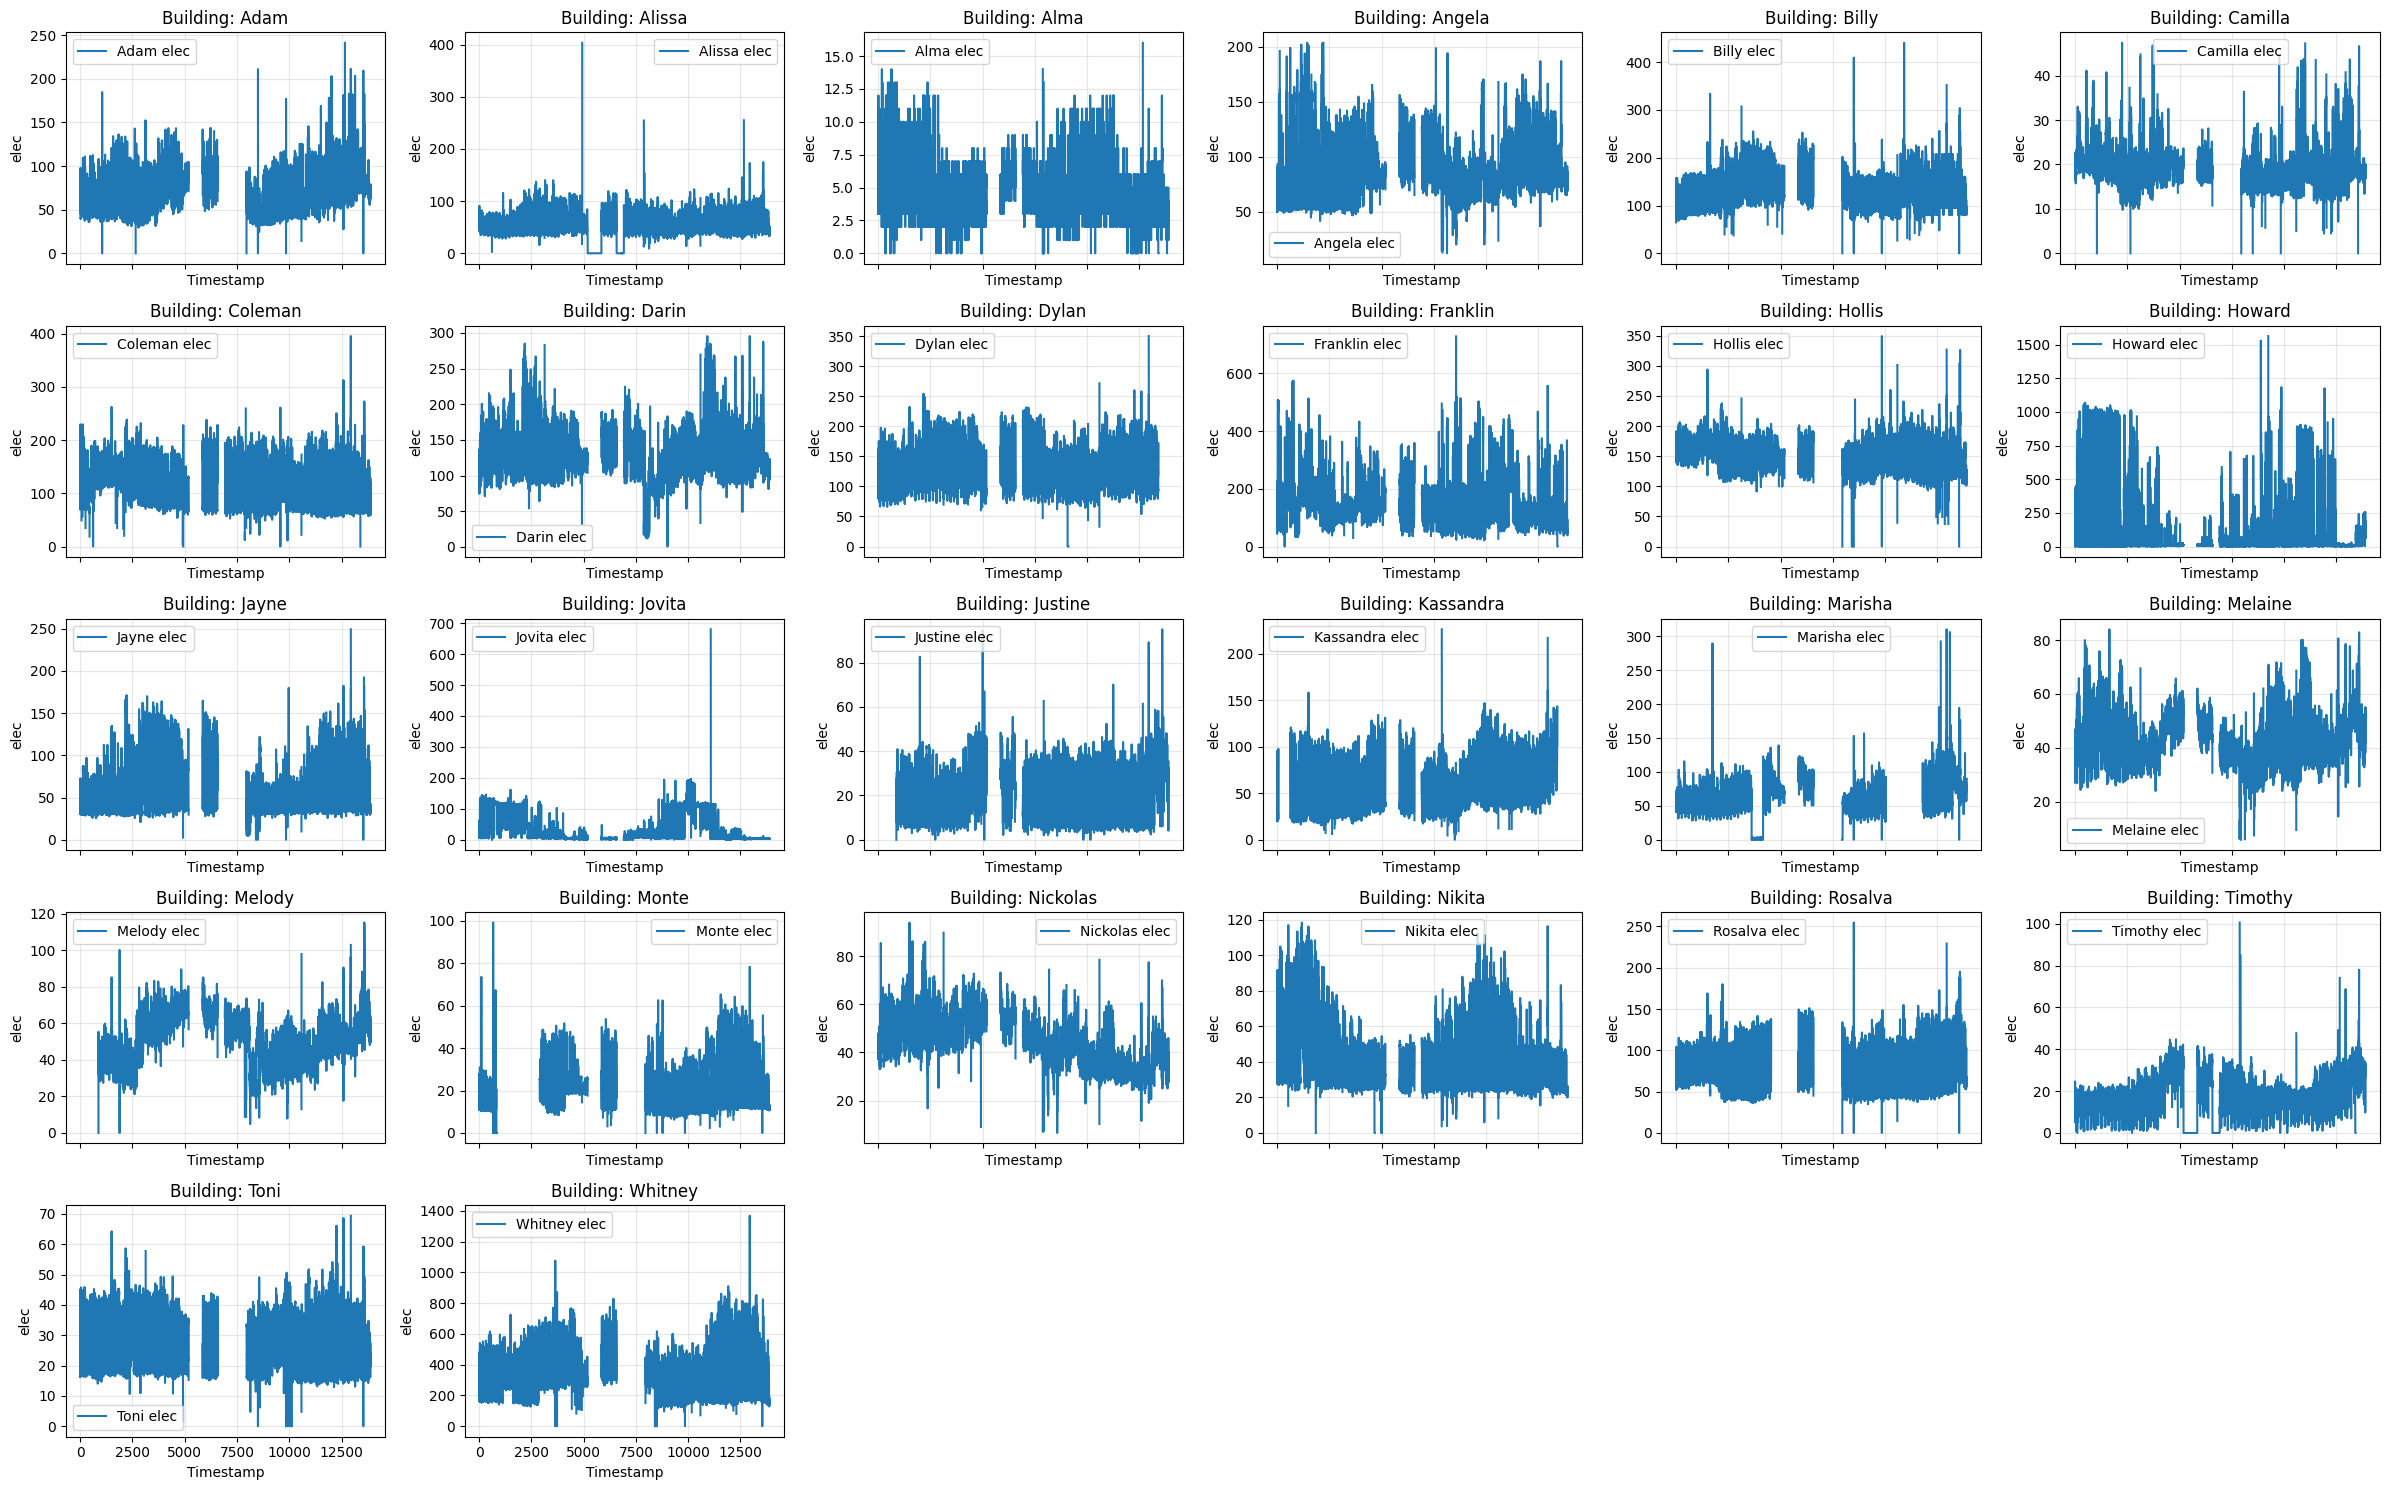

In [24]:
plot_buildings_matrix(data_for_plot, metric="elec")

chilled water

In [25]:
# chw 관련 전체가 Nan인 건물 제거
#   Alma, Coleman, Darin, Hollis, Justine, Melaine, Melody, Nickolas, Nikita, Timothy
# long_df는 이미 Nan행인 상태
# data(data_for_plot)에서는 Nan 행은 애초에 열 존재하지 않음

# chw 관련 전체 Nan으로 처리할 건물 (모델 학습 시 제외)
# Franklin, whitney
# long_df: building_name 열의 값이 Franklin, whitney인 동일 행의 chw 열 전체 NaN
long_df.loc[long_df["building_name"].isin(["Franklin", "whitney"]), "chw"] = np.nan

# data_for_plot 에서 Franklin, Whitney_chw 열 모두 drop
for col in ["Franklin_chw", "Whitney_chw"]:
    if col in data_for_plot.columns:   # 열이 존재할 때만
        data_for_plot.drop(columns=col, inplace=True)

'chw' 데이터 없는 건물: Alma, Coleman, Darin, Franklin, Hollis, Justine, Melaine, Melody, Nickolas, Nikita, Timothy, Whitney


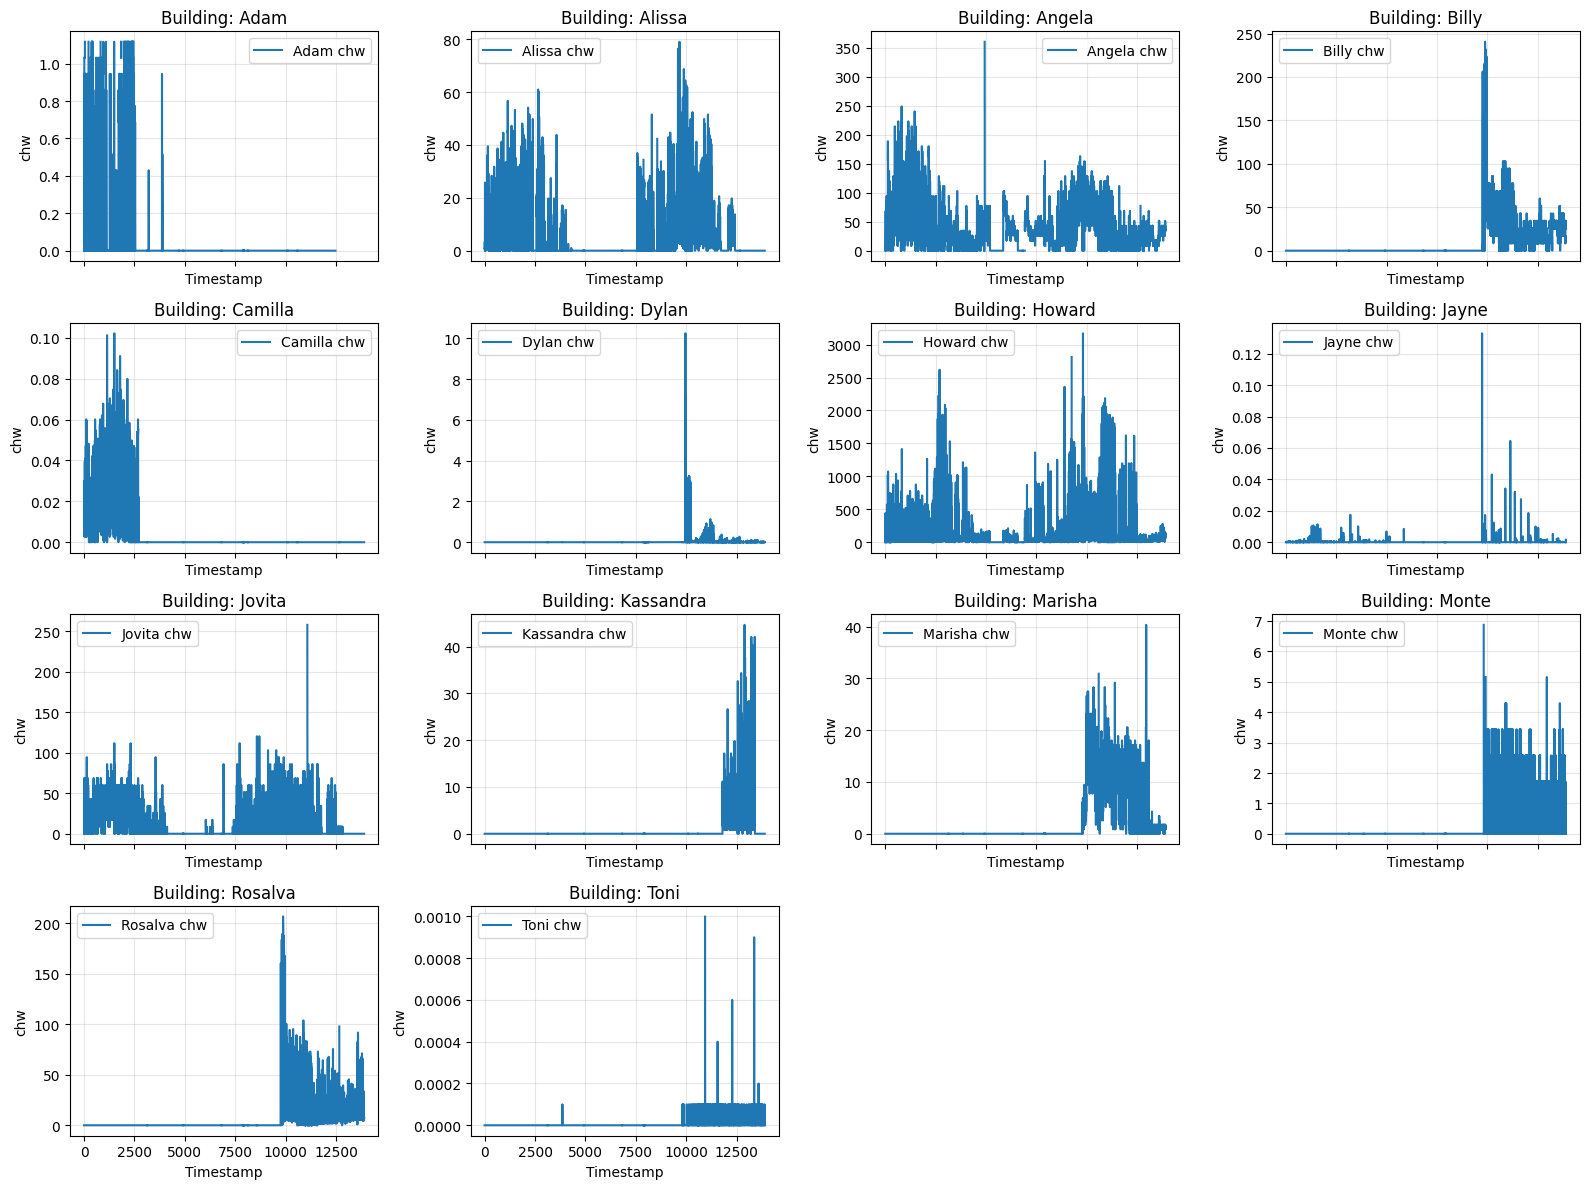

In [26]:
plot_buildings_matrix(data_for_plot, metric="chw")

hot water

'hw' 데이터 없는 건물: Adam, Alma, Coleman, Darin, Franklin, Hollis, Howard, Jayne, Jovita, Justine, Kassandra, Melaine, Melody, Nickolas, Nikita, Timothy, Whitney


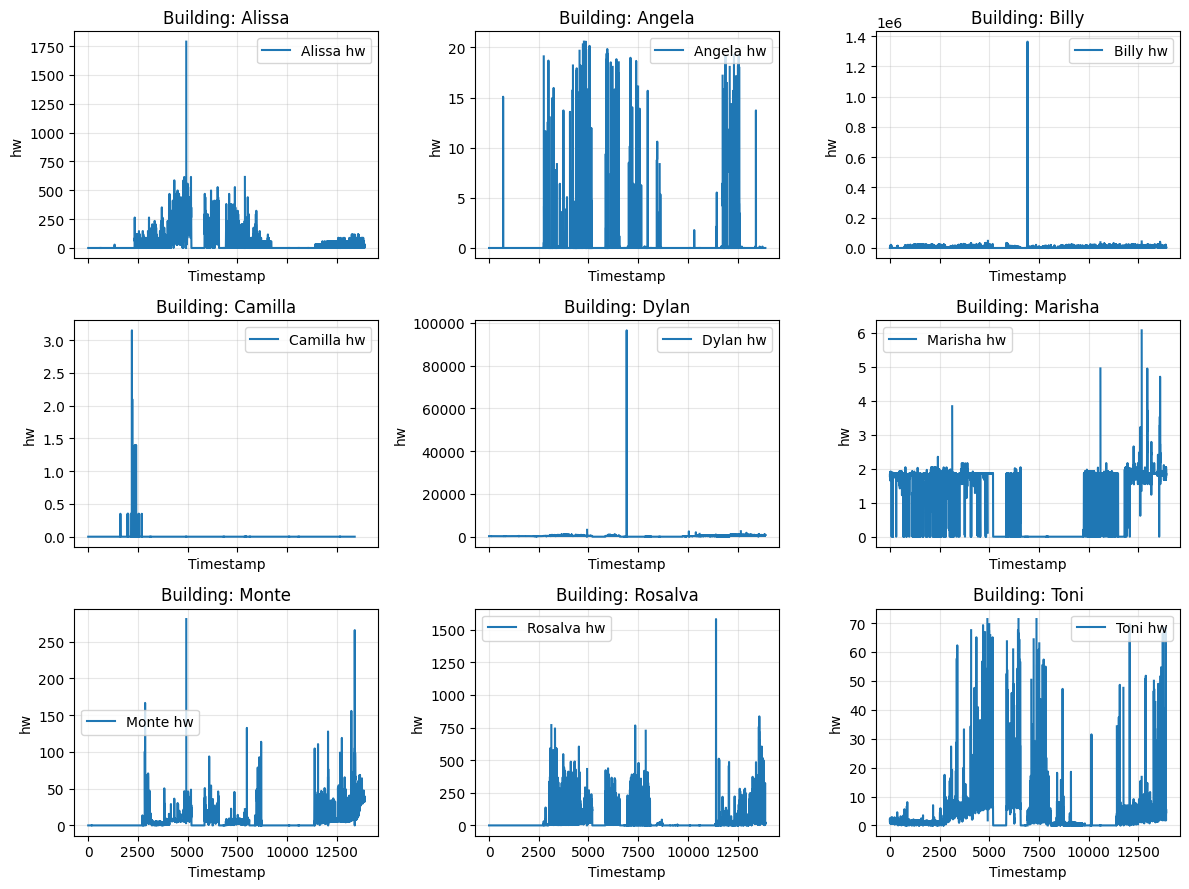

In [27]:
plot_buildings_matrix(data_for_plot, metric="hw")

water

In [28]:
# water 관련 전체 Nan으로 처리할 건물 (모델 학습 시 제외)
# Alissa, Melody
# long_df: building_name 열의 값이 Alissa, Melody인 동일 행의 water 열 전체 NaN
long_df.loc[long_df["building_name"].isin(["Alissa", "Melody"]), "water"] = np.nan

# data_for_plot 에서 Alissa, Melody_water 열 모두 drop
for col in ["Alissa_water", "Melody_water"]:
    if col in data_for_plot.columns:   # 열이 존재할 때만
        data_for_plot.drop(columns=col, inplace=True)

'water' 데이터 없는 건물: Alissa, Alma, Hollis, Jayne, Melody


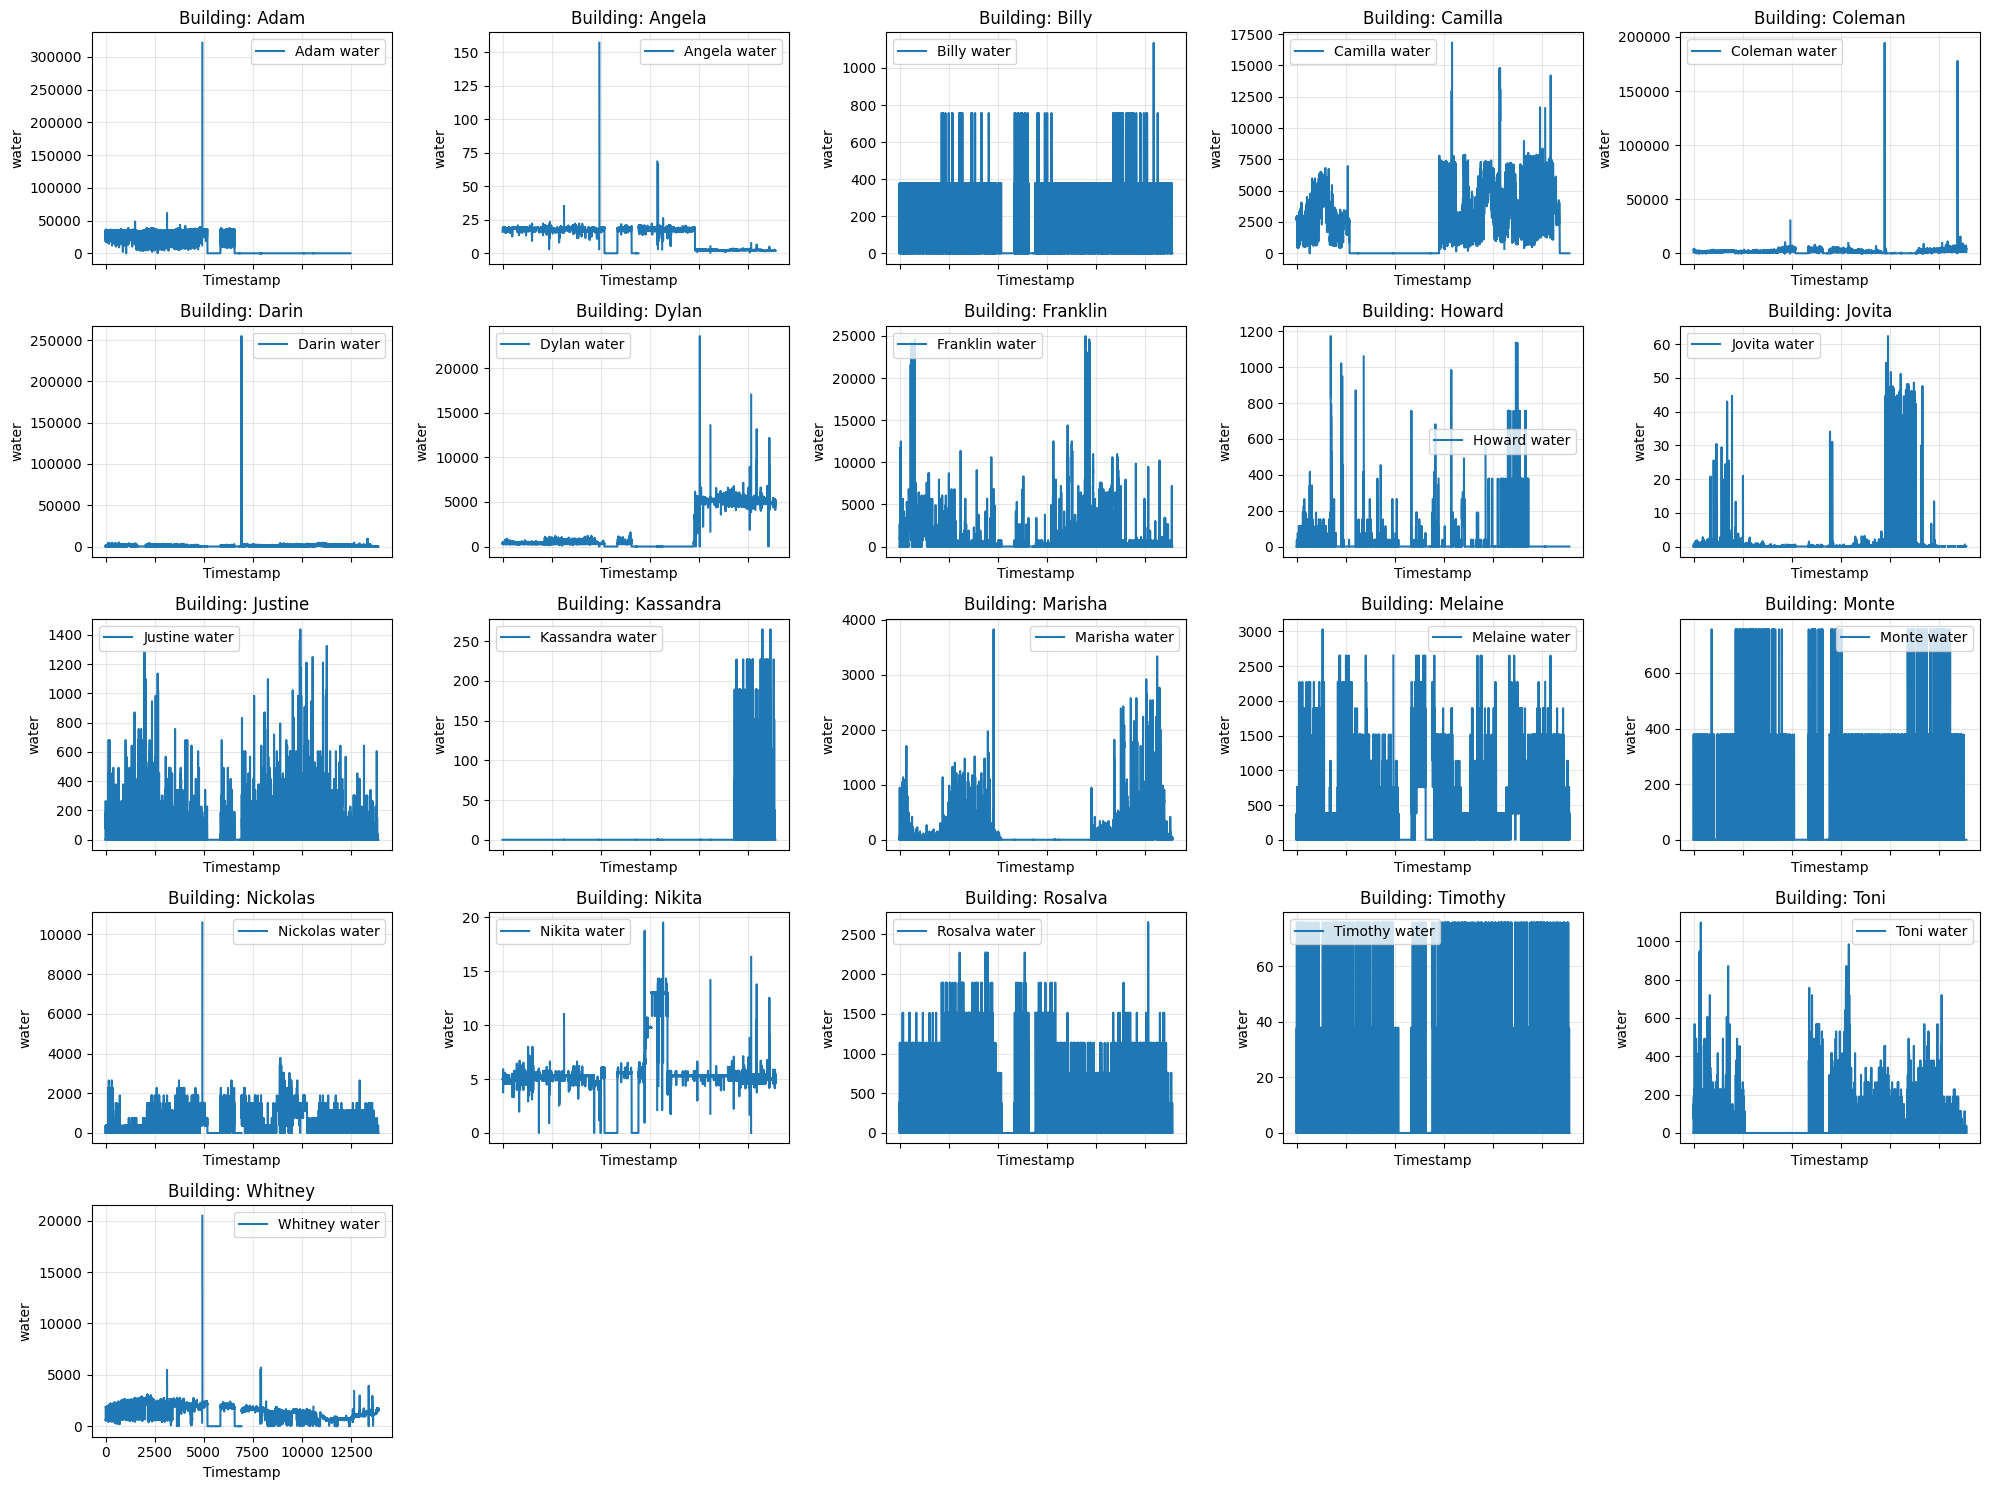

In [29]:
plot_buildings_matrix(data_for_plot, metric="water")

gas

'gas' 데이터 없는 건물: Adam, Alma, Angela, Billy, Camilla, Coleman, Dylan, Hollis, Howard, Jayne, Jovita, Kassandra, Marisha, Melody, Monte, Nickolas, Rosalva, Timothy, Toni, Whitney


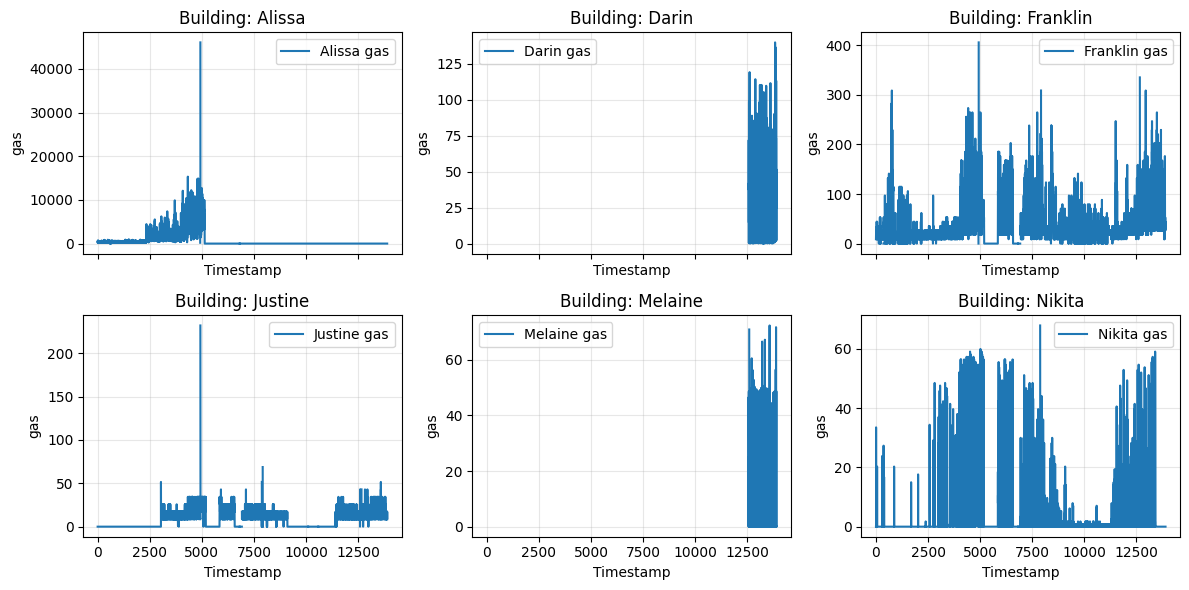

In [30]:
plot_buildings_matrix(data_for_plot, metric="gas")

solar

In [31]:
# solar 관련 전체 Nan으로 처리할 건물 (모델 학습 시 제외)
# Justine
# long_df: building_name 열의 값이 Justine인 동일 행의 solar 열 전체 NaN
long_df.loc[long_df["building_name"].isin(["Justine"]), "solar"] = np.nan

# data_for_plot 에서 Justine_solar 열 모두 drop
for col in ["Justine_solar"]:
    if col in data_for_plot.columns:   # 열이 존재할 때만
        data_for_plot.drop(columns=col, inplace=True)

'solar' 데이터 없는 건물: Adam, Alma, Angela, Billy, Camilla, Darin, Franklin, Hollis, Howard, Jayne, Jovita, Justine, Kassandra, Marisha, Melaine, Melody, Monte, Nickolas, Nikita, Rosalva, Toni, Whitney


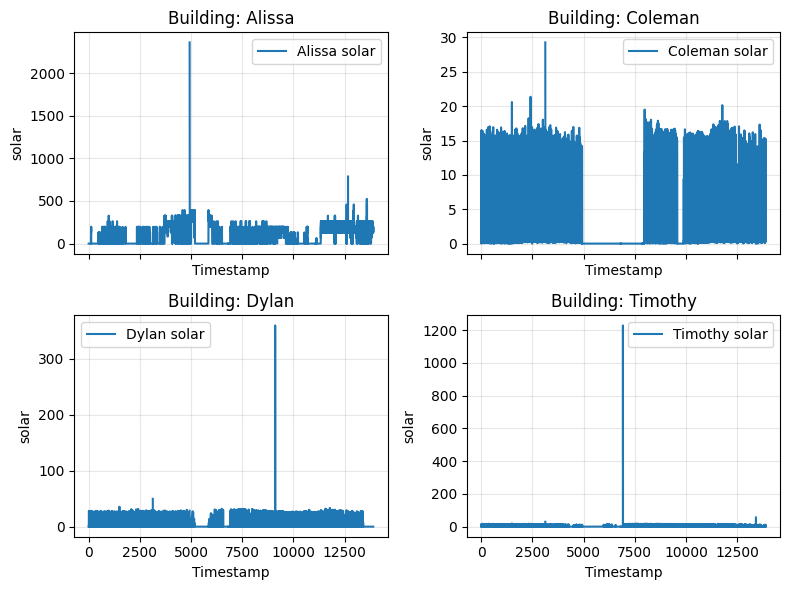

In [32]:
plot_buildings_matrix(data_for_plot, metric="solar")

In [33]:
# # 검사: long_df의 특정 building_name의 특정 열 전체가 Nan인지 출력

# print("전체가 NaN인 건물_측정값:")
# # Justine의 solar 열 전체가 Nan인지 확인
# building_name = "Justine"
# measure = "solar"
# if long_df.loc[long_df["building_name"] == building_name, measure].isna().all():
#     print(f"{building_name}_{measure}")

## 데이터 전처리

전처리 step

0. timestamp를 통한 정렬
    - long_df, commondata timestamp 오름차순
1. train / valid / test 분리
    - train / valid / test를 날짜로 끊고, 이후 단계의 모든 “fit(기준 계산)”은 train만 사용.
2. 데이터 전처리
    - 이상치 NaN값 처리 (train IQR 기준 저장)
    - 결측치 보정
    - Feature Engineering
    - 타겟 로그 변환
    - Min/Max 정규화
3. 슬라이딩 윈도우 생성 및 데이터 합치기

### 0. timestamp를 통한 정렬
- long_df, common data timestamp 오름차순

In [34]:
#   중복 제거 및 정렬 
def make_hourly_long(df, keys, ts="timestamp", freq="h"):
    """
    Function: make_hourly_long
        - long_df에서 keys(그룹 키)별로 정렬·중복 제거 후 각 그룹에 대해 1시간 간격으로 시간 축 보강
    Parameters:
        - df: long 형태 데이터프레임. ts와 keys 포함
        - keys: 엔티티를 식별하는 컬럼들(["building_name"])
        - ts: 타임스탬프 열 이름 (기본값: "timestamp")
        - freq: 재인덱싱 주기 (기본값: "h")
    Returns:
        - pd.DataFrame: 각 그룹별로 1시간 간격으로 시간축 보강된 long 데이터
    """
    df = df.copy()
    df[ts] = pd.to_datetime(df[ts]) # timestamp 형태 변환
    df = df.drop_duplicates(subset=keys + [ts], keep="first") # 건물별 그룹 + timestamp 중복 제거(첫 행 보존)
    df = df.sort_values(keys + [ts]) # 그룹(건물)별 시계열 데이터로 정렬 

    out = [] # 그룹별 결과 누적 리스트
    for gvals, g in df.groupby(keys, dropna=False): # 건물별 반복
        # 각 그룹의 전체 시간축 생성
        idx = pd.date_range(g[ts].min(), g[ts].max(), freq=freq) 
        # 시간축에 맞춰 재인덱싱(빈 시각은 NaN)
        g2 = g.set_index(ts).reindex(idx) 
        # 인덱스 이름을 ts로 복구
        g2.index.name = ts 
        # tuple이 아닌 경우 tuple로 변환
        if not isinstance(gvals, tuple):
            gvals = (gvals,)
        for k, v in zip(keys, gvals):
            g2[k] = v # 해당 건물에 대한 값 할당 
        out.append(g2.reset_index()) # 그룹별 결과 누적, 인덱스 복원

    out = pd.concat(out, ignore_index=True) if out else df.copy() # 그룹별 결과 병합
    # 정렬 유지(그룹별 시계열 순서 정렬)
    out = out.sort_values(keys + [ts]).reset_index(drop=True)
    return out

def make_hourly(df, ts="timestamp", freq="h"):
    """
    Function: make_hourly
        - common 데이터에서 timestamp 기준으로 정렬·중복 제거 후 1시간 간격으로 시간 축 보강
        - 그룹 필요 없음 (공통 시계열 데이터이므로)
    Parameters:
        - df: common 데이터프레임
        - ts: 타임스탬프 열 이름 (기본값: "timestamp")
        - freq: 재인덱싱 주기 (기본값: "h")
    Returns:
        - pd.DataFrame: 1시간 간격으로 시간축 보강된 common 데이터
    """
    df = df.copy() # 원본 보호
    df[ts] = pd.to_datetime(df[ts]) # 타임스탬프 형태 변환
    df = df.sort_values(ts) # 시간 정렬
    df = df.drop_duplicates(subset=[ts], keep="first") # 같은 시각 중복 제거(첫 행 보존)

    # 전체 시간축 생성
    full_index = pd.date_range(df[ts].min(), df[ts].max(), freq=freq) 
    # 시간축에 맞춰 재인덱싱(빈 시각은 NaN)
    df = df.set_index(ts).reindex(full_index)
    # 인덱스 이름을 ts로 복구
    df = df.rename_axis(ts).reset_index()
    return df

In [35]:
# long_df: long 포맷(key - building_name / building_name별 시계열 데이터)
long_df = make_hourly_long(long_df.reset_index(), keys=["building_name"], ts="timestamp", freq="h")

# common: 기본 포맷(한 시각 = 한 행)
common = make_hourly(common.reset_index(), ts="timestamp", freq="h")

### 1. train / valid / test 분리
- train / valid / test를 날짜로 끊고, 이후 단계의 모든 “fit(기준 계산)”은 train만 사용.

In [36]:
def make_weekly_bounds(
    data_index: pd.DatetimeIndex | None = None,
    train_raw_start="2016-06-01 00:00:00", train_raw_end="2017-05-31 23:00:00",
    valid_raw_start="2017-06-01 00:00:00", valid_raw_end="2017-08-31 23:00:00",
    test_raw_start="2017-09-01 00:00:00", test_raw_end="2017-12-31 23:00:00",
    gap_days=7
):
    """
    Function: make_weekly_bounds
        - 주 단위 경계로 train/valid/test 구간 설정
        - 각 구간은 월요일 시작, 일요일 종료
        - 구간 간 최소 gap_days(일 단위) 간격 유지
    Parameters:
        - data_index: 전체 데이터의 DatetimeIndex (범위 확인용, 기본값: None)
        - train_raw_start, train_raw_end: train 구간 원시 시작/끝 시각 (문자열 또는 pd.Timestamp)
        - valid_raw_start, valid_raw_end: valid 구간 원시 시작/끝 시각 (문자열 또는 pd.Timestamp)
        - test_raw_start, test_raw_end: test 구간 원시 시작/끝 시각 (문자열 또는 pd.Timestamp)
        - gap_days: 구간 간 최소 간격(일 단위, 기본값: 7ㅇ일)
    Returns:
        - Tuple of Tuples: ((train_start, train_end), (valid_start, valid_end), (test_start, test_end))
          각 구간의 시작/끝 시각은 pd.Timestamp 형태로 반환
    """
    def week_start_monday(ts):
        """
        Function: week_start_monday
            - 입력 시각 이후(혹은 동일)의 월요일 00:00으로 정렬
        Parameters: 
            - ts: 입력 시각 (문자열 또는 pd.Timestamp)
        Returns:
            - pd.Timestamp: 월요일 00:00으로 정렬된 시각
        """
        ts = pd.Timestamp(ts) # pd.Timestamp로 변환
        # 월요일(0)이면 그 날 00시, 아니면 다음 월요일 00시
        base = ts.normalize() # 시간대를 00:00:00으로 변환
        if ts.weekday() == 0: # 월요일이면 그날 사용 
            return base  # 월요일
        # 다음 월요일 00:00:00
        return (base + pd.offsets.Week(weekday=0)) # pd.offsets.Week(weekday=0) 주 단위 이동 (다음 월요일)

    def week_end_sunday_23h(ts):
        """
        Function: week_end_sunday_23h
            - 입력 시각 이전(혹은 동일)의 일요일 23:00으로 정렬
        Parameters:
            - ts: 입력 시각 (문자열 또는 pd.Timestamp)
        Returns:
            - pd.Timestamp: 일요일 23:00으로 정렬된 시각
        """
        ts = pd.Timestamp(ts) # timestamp로 변환
        # 일요일(6)이면 그 날 23:00, 아니면 이전 일요일 23:00
        base = ts.normalize() # 시간대를 00:00:00으로 변환
        if ts.weekday() == 6: # 일요일이면 그날 사용
            return base + pd.Timedelta(hours=23)
        # 바로 이전 일요일
        prev_sun = base - pd.offsets.Week(weekday=6)
        return prev_sun + pd.Timedelta(hours=23) # 일요일의 23시까지 

    # 전체 데이터 범위
    if data_index is not None and len(data_index) > 0: # 유효한 인덱스가 있으면
        global_start = pd.to_datetime(data_index.min()) # 가장 빠른 시각
        global_end = pd.to_datetime(data_index.max()) # 가장 늦은 시각
    else:
        global_start = pd.Timestamp.min + pd.Timedelta(days=1) 
        global_end   = pd.Timestamp.max - pd.Timedelta(days=1)
        
    # 원시 구간 시각
    tr_s_raw, tr_e_raw = pd.Timestamp(train_raw_start), pd.Timestamp(train_raw_end) # train: 2016.06.01 ~ 2017.05.31
    va_s_raw, va_e_raw = pd.Timestamp(valid_raw_start), pd.Timestamp(valid_raw_end) # valid: 2017.06.01 ~ 2017.08.31
    te_s_raw, te_e_raw = pd.Timestamp(test_raw_start),  pd.Timestamp(test_raw_end) # test: 2017.09.01 ~ 2017.12.31

    # 월 - 일요일 형태로 변환 
    train_start = week_start_monday(max(tr_s_raw, global_start)) # train 시작: 2016.06.01 이후의 첫 월요일
    train_end = week_end_sunday_23h(min(tr_e_raw, global_end)) # train 끝: 2017.05.31 이전의 마지막 일요일 23시

    valid_start_nominal = week_start_monday(max(va_s_raw, global_start)) # valid 시작: 2017.06.01 이후의 첫 월요일
    valid_end = week_end_sunday_23h(min(va_e_raw, global_end)) # valid 끝: 2017.08.31 이전의 마지막 일요일 23시

    test_start_nominal = week_start_monday(max(te_s_raw, global_start)) # test 시작: 2017.09.01 이후의 첫 월요일
    test_end = week_end_sunday_23h(min(te_e_raw, global_end)) # test 끝: 2017.12.31 이전의 마지막 일요일 23시

    # gap 추가하기 (7일)
    # valid 시작: nominal + 7일
    valid_start = week_start_monday(valid_start_nominal + pd.Timedelta(days=gap_days)) # 최종 valid 시작: 2017.06.12 이후의 첫 월요일
    # test 시작: nominal + 7일
    test_start = week_start_monday(test_start_nominal + pd.Timedelta(days=gap_days)) # 최종 test 시작: 2017.09.11 이후의 첫 월요일

    # 구간 유효성 검사 - 구간 출력하기 
    print(f"Train: {train_start} ~ {train_end} ({(train_end - train_start).days + 1}일)")
    print(f"Valid: {valid_start} ~ {valid_end} ({(valid_end - valid_start).days + 1}일)")
    print(f"Test: {test_start} ~ {test_end} ({(test_end - test_start).days + 1}일)")

    return (
        (train_start, train_end), # 2016-06-06(월) 00:00:00 ~ 2017-05-28(일) 23:00:00
        (valid_start, valid_end), # 2017-06-12(월) 00:00:00 ~ 2017-08-27(일) 23:00:00
        (test_start,  test_end), # 2017-09-11(월) 00:00:00 ~ 2017-12-31(일) 23:00:00
    )

def _hourly_index(s, e):
    """
    Function: _hourly_index
        - 시각 start부터 end까지 1시간 간격의 DatetimeIndex 생성
        - 
    Parameters:
        - s: 시작(start) 시각 (문자열 또는 pd.Timestamp)
        - e: 끝(end) 시각 (문자열 또는 pd.Timestamp)
    Returns:
        - pd.DatetimeIndex: start부터 end까지 1시간 간격의 시각 인덱스
    """
    return pd.date_range(pd.Timestamp(s), pd.Timestamp(e), freq="h") # freq = h: 1시간 간격

def _ensure_dtindex(df: pd.DataFrame, ts_col="timestamp"):
    """
    Function: _ensure_dtindex
        - DataFrame의 인덱스를 DatetimeIndex로 변환하는 함수 
        - timestamp 열이 존재 -> 해당 열을 DatetimeIndex로 변환하여 인덱스로 설정
        - timestamp가 이미 인덱스일 때 -> DatetimeIndex라면 그대로 사용, 아니면 오류 발생
    Parameters:
        - df: 대상 DataFrame
        - ts_col: timestamp" 열
    Returns:
        - pd.DataFrame: 인덱스가 DatetimeIndex로 변환된 DataFrame
    """
    out = df.copy()
    if ts_col in out.columns: # ts_col이 열에 있으면
        out[ts_col] = pd.to_datetime(out[ts_col], errors="coerce") # 날짜형으로 변환
        out = out.set_index(ts_col) # ts_col을 인덱스로 설정
    elif not isinstance(out.index, pd.DatetimeIndex): # ts_col이 열에 없고, 인덱스가 DatetimeIndex가 아니면
        raise ValueError("DatetimeIndex가 없음. timestamp 열을 전달해야 함. ")
    return out.sort_index() # pd.DataFrame

In [37]:
def split_common_by_bounds(df: pd.DataFrame, bounds):
    """
    Function: split_common_by_bounds
        - common을 주어진 경계(bounds)로 train/valid/test 구간으로 분할
        - 각 구간은 1시간 간격으로 재인덱싱
    Parameters:
        - df: common (timestamp 열 또는 DatetimeIndex 필요)
        - bounds: make_weekly_bounds() 함수의 반환값 # ((train_start, train_end), (valid_start, valid_end), (test_start, test_end))
    Returns:
        - common 데이터 프레임 tuple (train_df, valid_df, test_df)
    """
    df2 = _ensure_dtindex(df, ts_col="timestamp") # df의 인덱스를 DatetimeIndex로 변환
    (tr_s, tr_e), (va_s, va_e), (te_s, te_e) = bounds # 경계 추출

    def cut_and_reindex(df2, s, e):
        """
        Function: cut_and_reindex
            - 데이터 d에서 s~e 구간 추출 후 1시간 간격으로 재인덱싱
        Parameters:
            - d: 대상 데이터 (pd.DataFrame, DatetimeIndex 필요)
            - s: 시작 시각 (문자열 또는 pd.Timestamp)
            - e: 끝 시각 (문자열 또는 pd.Timestamp)
        Returns:
            - pd.DataFrame: s~e 구간을 1시간 간격으로 재인덱싱한 데이터
        """
        idx = _hourly_index(s, e) # 1시간 간격 인덱스 생성
        out  = df2.loc[s:e] # 시작 - 끝 구간 추출
        out  = out.reindex(idx) # 1시간격 강제
        return out.rename_axis("timestamp").reset_index() # 인덱스 이름 복구 및 열로 변환

    tr = cut_and_reindex(df2, tr_s, tr_e) # train 구간: 2016-06-06 ~ 2017-05-28
    va = cut_and_reindex(df2, va_s, va_e) # valid 구간: 2017-06-12 ~ 2017-08-27
    te = cut_and_reindex(df2, te_s, te_e) # test 구간: 2017-09-11 ~ 2017-12-31
    return tr, va, te

In [38]:
def split_long_by_bounds(df: pd.DataFrame, keys: List[str], bounds):
    """
    Function: split_long_by_bounds
        - long_df를 keys(건물)별로 bounds(구간 경계) 기준으로 train/valid/test로 분할
        - 각 구간은 1시간 간격으로 재인덱싱
    Parameters:
        - df: long 형태 데이터프레임. timestamp와 keys 포함
        - keys: 엔티티를 식별하는 컬럼들(["building_name"])
        - bounds: ((train_start, train_end), (valid_start, valid_end), (test_start, test_end))
    Returns:
        - long_df 데이터프레임의 tuple: (train_df, valid_df, test_df)
        - 각 구간의 데이터프레임: keys + timestamp + 측정값 열
    """
    df2 = _ensure_dtindex(df, ts_col="timestamp") # 인덱스를 DatetimeIndex로 변환
    (tr_s, tr_e), (va_s, va_e), (te_s, te_e) = bounds # 구간 경계(시작 - 끝) 추출

    # 반환 열 목록 
    cols = df2.reset_index().columns

    def cut_and_reindex_group(g, s, e):
        """
        Function: cut_and_reindex_group
            - 그룹 g를 시각 s~e로 자르고 1시간 간격으로 재인덱싱 # 그룹: 건물별 
            - keys 열 값 복원
        Parameters:
            - g: 그룹 데이터프레임
            - s: 시작(start) 시각 (문자열 또는 pd.Timestamp)
            - e: 끝(end) 시각 (문자열 또는 pd.Timestamp)
        Returns:
            - pd.DataFrame: 재인덱싱된 그룹 데이터프레임
        """
        idx = _hourly_index(s, e) # 1시간 간격 인덱스 생성
        g2  = g.loc[s:e].reindex(idx) # 그룹 내부(건물 별)에서 시간 슬라이싱 + 재인덱스
        g2.index.name = "timestamp" # 인덱스 이름 복원
        # 그룹 키 복구(건물 이름)
        for k in keys:
            g2[k] = (g[k].iloc[0] if k in g.columns else None) # 그룹 키 복원
        return g2.reset_index() # 인덱스 복원

    out_tr, out_va, out_te = [], [], [] # 구간별 결과 누적 리스트
    # 건물별 그룹핑
    for _, g in df2.groupby(keys, dropna=False, sort=False): # sort=False로 원순서 유지
        out_tr.append(cut_and_reindex_group(g, tr_s, tr_e)) # train 구간: 2016-06-06 ~ 2017-05-28
        out_va.append(cut_and_reindex_group(g, va_s, va_e)) # valid 구간: 2017-06-12 ~ 2017-08-27
        out_te.append(cut_and_reindex_group(g, te_s, te_e)) # test 구간: 2017-09-11 ~ 2017-12-31

    cat = lambda parts: (pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=cols)) # 결과 병합 함수
    tr = cat(out_tr); va = cat(out_va); te = cat(out_te) # 구간별 결과 병합

    # 건물별 시계열 정렬 유지
    tr = tr.sort_values(keys + ["timestamp"]).reset_index(drop=True)
    va = va.sort_values(keys + ["timestamp"]).reset_index(drop=True)
    te = te.sort_values(keys + ["timestamp"]).reset_index(drop=True)
    return tr, va, te

In [39]:
# 인덱스를 timestamp로 맞춤
common_dt = _ensure_dtindex(common,  ts_col="timestamp")
long_df_dt = _ensure_dtindex(long_df, ts_col="timestamp")

# train / valid / test 구간 경계 생성
bounds = make_weekly_bounds() # ((train_start, train_end), (valid_start, valid_end), (test_start, test_end))
train_cmn, valid_cmn, test_cmn = split_common_by_bounds(common_dt, bounds)
train_long, valid_long, test_long = split_long_by_bounds(long_df_dt, keys=["building_name"], bounds=bounds)

# 구간 경계 출력 
print(f"common:\n train_cmn: {len(train_cmn)}, valid_cmn: {len(valid_cmn)}, test_cmn: {len(test_cmn)}")
print(f"long_df:\n train_long: {len(train_long)}, valid_long: {len(valid_long)}, test_long: {len(test_long)}")

Train: 2016-06-06 00:00:00 ~ 2017-05-28 23:00:00 (357일)
Valid: 2017-06-12 00:00:00 ~ 2017-08-27 23:00:00 (77일)
Test: 2017-09-11 00:00:00 ~ 2017-12-31 23:00:00 (112일)
common:
 train_cmn: 8568, valid_cmn: 1848, test_cmn: 2688
long_df:
 train_long: 222768, valid_long: 48048, test_long: 69888


### 2. 데이터 전처리
- 이상치 NaN값 처리 (train IQR 기준 저장)
- 결측치 보정 (train의 평균값 저장)
- Feature Engineering
- 타겟 로그 변환
- Min/Max 정규화

- 이상치 NaN값으로 처리

In [40]:
# IQR 이상치 - NaN 대체 
def handle_outliers_iqr(df, factor=1.5, df_name="df"):
    """
    Function: handle_outliers_iqr
        1. df의 수치형 컬럼별로 IQR 기반 이상치를 NaN으로 대체
        2. 이상치 개수를 컬럼별로 출력
    Parameters:
        - df: 처리할 DataFrame
        - factor: IQR 배수 (기본값: 1.5)
        - df_name: DataFrame 이름 (기본값: "df")
    Returns:
        - pd.DataFrame: 이상치가 NaN으로 대체된 DataFrame
    """
    df = df.copy()
    
    outliers = {} # 전체 컬럼별 이상치 기록
    numeric_cols = df.select_dtypes(include=[np.number]).columns # 수치형 컬럼만 처리
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25) # 1사분위수
        Q3 = df[col].quantile(0.75) # 3사분위수
        IQR = Q3 - Q1 # 이상치
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # 이상치 인덱스
        mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers[col] = df.loc[mask, col]
        
        # 이상치를 NaN으로 처리
        df.loc[mask, col] = np.nan

    # 이상치 개수 출력
    print(f"{df_name}의 이상치 개수:")
    for col, series in outliers.items():
        print(f"{col:<15}: {series.shape[0]}")
    print("\n")
    return df

In [41]:
train_long  = handle_outliers_iqr(train_long, factor=1.5, df_name="train_long")
valid_long  = handle_outliers_iqr(valid_long, factor=1.5, df_name="valid_long")
test_long   = handle_outliers_iqr(test_long,  factor=1.5, df_name="test_long")
print("============================")
train_cmn = handle_outliers_iqr(train_cmn, factor=1.5, df_name="train_common")
valid_cmn = handle_outliers_iqr(valid_cmn, factor=1.5, df_name="valid_common")
test_cmn  = handle_outliers_iqr(test_cmn,  factor=1.5, df_name="test_common")

train_long의 이상치 개수:
elec           : 6942
chw            : 23260
hw             : 17410
gas            : 6313
solar          : 4356
water          : 31113


valid_long의 이상치 개수:
elec           : 1664
chw            : 4815
hw             : 3892
gas            : 1675
solar          : 777
water          : 7191


test_long의 이상치 개수:
elec           : 1864
chw            : 4915
hw             : 5166
gas            : 639
solar          : 2342
water          : 7270


train_common의 이상치 개수:
airTemperature : 0
cloudCoverage  : 565
dewTemperature : 168
precipDepth1HR : 1027
seaLvlPressure : 157
windDirection  : 0
windSpeed      : 459
dow_sin        : 0
dow_cos        : 0
is_weekend     : 0
hour_sin       : 0
hour_cos       : 0


valid_common의 이상치 개수:
airTemperature : 0
cloudCoverage  : 57
dewTemperature : 40
precipDepth1HR : 61
seaLvlPressure : 11
windDirection  : 131
windSpeed      : 45
dow_sin        : 0
dow_cos        : 0
is_weekend     : 0
hour_sin       : 0
hour_cos       : 0


test_common의 이상치

In [42]:
# 결측치 확인
# long_df
print("train_long 결측치 개수:")
print(train_long.isna().sum())
print("============================")
# common
print("\ntrain_common 결측치 개수:")
print(train_cmn.isna().sum())
print("============================")
# meta # 결측치 없음
print("\nmeta 결측치 개수:")
print(meta.isna().sum())

train_long 결측치 개수:
timestamp             0
building_name         0
elec              48443
chw              118560
hw               163761
gas              194891
solar            192922
water             74733
dtype: int64

train_common 결측치 개수:
timestamp            0
airTemperature      28
cloudCoverage     3142
dewTemperature     199
precipDepth1HR    1033
seaLvlPressure     302
windDirection      476
windSpeed          539
dow_sin              0
dow_cos              0
is_weekend           0
hour_sin             0
hour_cos             0
dtype: int64

meta 결측치 개수:
building_name        0
primaryspaceusage    0
sqm                  0
sqft                 0
numberoffloors       0
dtype: int64


- 결측치 보정하기

In [43]:
# long_df 보정할 열 분류
LONG_NUMERIC = ["chw", "elec", "hw", "water", "solar", "gas"]

# common 연속형 / 불연속형 분류
COMMON_CONTINUOUS = [
    "airTemperature", "dewTemperature", "seaLvlPressure", "windDirection", "windSpeed"
]
COMMON_DISCRETE = [ # 0, 1 이산값 형태
    "cloudCoverage", "precipDepth1HR"
]
# 전체 수치형
COMMON_NUMERIC = COMMON_CONTINUOUS + COMMON_DISCRETE

In [44]:
# Fit (train 데이터에서만. 결측 보정용 '기준값' 계산)
def fit_imputer_stats(
    train_long, train_common,
    long_group_key: str = "building_name",
    fill_stat: Literal["mean", "median"] = "mean", # 평균 사용
    ):
    """
    Function: fit_imputer_stats
        - train_long과 train_common에서 결측 보정용 통계치 계산
        - long_df: 
            - long_group_key별로 그룹화
            - 각 그룹 내에서 시간보간 및 ffill/bfill 적용 후 통계치 계산
        - common: 
            - 전체 데이터에 대해 연속형/불연속형 구분
            - 보간 및 ffill/bfill 적용 후 통계치 계산
    Parameters:
        - train_long: long 포맷의 훈련 데이터프레임
        - train_common: wide 포맷의 훈련 데이터프레임
        - long_group_key: long_df에서 그룹화할 키 컬럼 (기본값: "building_name")
        - fill_stat: 통계치 유형 ("mean" 또는 "median", 기본값: "mean")
    Returns:
        - Dict[str, pd.Series]: {
            "long_stats": long_df 채움 값(열별),
            "common_stats": common 채움 값(열별),
            "fill_stat": 사용된 통계치 유형,
            "long_group_key": long_df 그룹 키,
            "long_cols": long_df 수치형 열 목록,
            "COMMON_CONTINUOUS": common 연속형 열 목록,
            "COMMON_DISCRETE
          }
    """
    # long (train)
    tl = _ensure_dtindex(train_long, "timestamp") # 인덱스를 DatetimeIndex로 변환

    # 시간보간 → ffill → bfill (train에서만)
    def _fill_long_group(g):
        """
        Function: _fill_long_group
            - long_df의 각 그룹에 대해 시간 보간 및 ffill/bfill 적용
        Parameters:
            - g: 그룹 데이터프레임
        Returns:
            - pd.DataFrame: 보간 및 채움이 적용된 그룹 데이터프레임
        """
        g2 = g.copy()
        g2[LONG_NUMERIC] = g2[LONG_NUMERIC].interpolate(method="time", limit_direction="both") # 시간 보간
        g2[LONG_NUMERIC] = g2[LONG_NUMERIC].ffill().bfill() # 앞/뒤 채움
        return g2
    tl_filled = tl.groupby(long_group_key, dropna=False, group_keys=False).apply(_fill_long_group)

    # common (train)
    tc = _ensure_dtindex(train_common, "timestamp")
    tc_filled = tc.copy()

    # 연속형: 보간 -> ffill -> bfill
    # "airTemperature", "dewTemperature", "seaLvlPressure", "windDirection", "windSpeed"
    if COMMON_CONTINUOUS:
        tc_filled[COMMON_CONTINUOUS] = (
            tc_filled[COMMON_CONTINUOUS]
            .interpolate(method="time", limit_direction="both") # 시간 보간
            .ffill().bfill() # 앞/뒤 채움
        )
    # 불연속형: 보간 -> ffill/bfill
    # "cloudCoverage", "precipDepth1HR"
    if COMMON_DISCRETE:
        tc_filled[COMMON_DISCRETE] = (
            tc_filled[COMMON_DISCRETE]
            .interpolate(method="time", limit_direction="both") # 시간 보간
            .ffill().bfill() # 앞/뒤 채움
        )

    # 통계치 계산
    # reducer: 평균값으로 채우기 
    reducer = np.nanmean if fill_stat == "mean" else np.nanmedian

    # 각 열의 평균을 저장한 Series 생성
    long_stats = pd.Series({c: reducer(tl_filled[c].values) for c in LONG_NUMERIC})
    common_stats = pd.Series({c: reducer(tc_filled[c].values) for c in COMMON_NUMERIC})

    return { # Dict[str, pd.Series]
        "long_stats": long_stats, # long_df 채움 값(열별 평균)
        "common_stats": common_stats, # common 채움 값(열별 평균)
        "fill_stat": fill_stat, 
        "long_group_key": long_group_key,
        "long_cols": LONG_NUMERIC,
        "COMMON_CONTINUOUS": COMMON_CONTINUOUS,
        "COMMON_DISCRETE": COMMON_DISCRETE,
    }

In [45]:
# Transform (train/valid/test 데이터에 결측 보정 적용)
def transform_long_with_stats(
    df, stats: Dict[str, pd.Series],
    split: Literal["train", "valid", "test"] = "train", # 그룹 g에 대해 split에 따라 결측 보정 적용
    return_mask_info: bool = True,
) -> pd.DataFrame | Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """
    Function: transform_long_with_stats
        - long 포맷 df에 결측 보정 적용
        - stats: fit_imputer_stats() 함수의 반환값
        - split: "train", "valid", "test" 중 하나 (기본값: "train")
            - train: 시간보간 + ffill/bfill + 통계치 채움
            - valid/test: ffill + 통계치 채움 (미래 정보 사용 금지)
        - return_mask_info: True면 (보정된 df, 마스크 정보 딕셔너리) 반환, False면 보정된 df만 반환
    Parameters:
        - df: long 포맷 데이터프레임 (timestamp 열 및 stats["long_group_key"] 포함)
        - stats: fit_imputer_stats() 함수의 반환값
        - split: "train", "valid", "test" 중 하나 (기본값: "train")
        - return_mask_info: True면 (보정된 df, 마스크 정보 딕셔너리) 반환, False면 보정된 df만 반환 (기본값: True)
    Returns:
        - pd.DataFrame 또는 Tuple[pd.DataFrame, Dict[str, List[str]]]:
            - return_mask_info가 False인 경우: 보정된 df
            - return_mask_info가 True인 경우: (보정된 df, 마스크 정보 딕셔너리)
            - 마스크 정보 딕셔너리: {그룹 키 값: [절대 채우지 않을 컬럼 목록]}
                (원본 split에서 전부 NaN이었던 컬럼은 이후 어떤 단계에서도 채우지 않음)
    """
    key = stats["long_group_key"] # 그룹 키(건물 이름)
    cols = stats["long_cols"] # long_df 수치형 열 목록
    fills = stats["long_stats"] # long_df 채움 값(열별)

    out = _ensure_dtindex(df, "timestamp")

    def _all_nan_cols_per_group(g):
        """
        Function: _all_nan_cols_per_group
            - 그룹 g에서 전부 NaN인 컬럼 목록 반환
        Parameters:
            - g: 그룹 데이터프레임
        Returns:
            - List[str]: 전부 NaN인 컬럼 목록
        """
        return [c for c in cols if not g[c].notna().any()] # List[str]

    mask_dict: Dict[str, List[str]] = {} # 그룹 키 값 → 전부 NaN인 컬럼 목록
    for bid, g in out.groupby(key, dropna=False): # 그룹별 검사
        # bid: 건물 이름, g: long_df
        mask_dict[bid] = _all_nan_cols_per_group(g) # 전부 NaN인 컬럼 목록 저장

    # 그룹별 결측 보정
    def _fill_group(g):
        """
        Function: _fill_group
            - 그룹 g에 대해 split에 따라 결측 보정 적용
            - split: "train", "valid", "test"
        Parameters:
            - g: 그룹 데이터프레임
        Returns:
            - pd.DataFrame: 결측 보정이 적용된 그룹 데이터프레임
        """
        g2 = g.copy()
        masked = set(mask_dict[g2[key].iloc[0]]) # 전부 NaN인 컬럼 집합 - 채우지 않음
        fillable = [c for c in cols if c not in masked] # 보정할 컬럼 목록

        if split == "train": # train: 앞/뒤 모두 채움 허용
            if fillable: # 선형 보간 + ffill/bfill
                g2[fillable] = g2[fillable].interpolate(method="time", limit_direction="both")
                g2[fillable] = g2[fillable].ffill().bfill()
        else:
            # val/test: 미래 보지 않음 
            if fillable: # ffill만 허용 (선형 보간, bfill 불가)
                g2[fillable] = g2[fillable].ffill()

        # 남은 NaN은 train 통계로 채우기. 이 때, 마스크 컬럼은 제외
        if fillable:
            # 문자열이 섞여 있을 수 있으므로 숫자형으로 변환
            g2[fillable] = g2[fillable].apply(pd.to_numeric, errors="coerce")

            # 남은 NaN을 train 통계로 채우기: 열 이름 → 스칼라 dict
            fill_map = {c: fills[c] for c in fillable}
            g2[fillable] = g2[fillable].fillna(value=fill_map)
            # masked 컬럼은 그대로(전부 NaN 유지)
            
        return g2 # pd.DataFrame

    # 그룹별 보정 적용
    out = out.groupby(key, dropna=False, group_keys=False).apply(_fill_group)
    
    # 인덱스 복구 및 정렬
    out = out.reset_index()
    out = out.sort_values([key, "timestamp"]).reset_index(drop=True)
    # out: 보정된 df # mask_dict: 그룹 키 값 → 전부 NaN인 컬럼 목록
    return (out, mask_dict) if return_mask_info else out 

In [46]:
def transform_common_with_stats(
    df, stats: Dict[str, pd.Series],
    split: Literal["train", "valid", "test"] = "train",
    discrete_fill_zero: bool = True,
) -> pd.DataFrame:
    """
    Function: transform_common_with_stats
        - common 포맷 df에 결측 보정 적용
        - stats: fit_imputer_stats() 함수의 반환값
        - split: "train", "valid", "test" 중 하나 (기본값: "train")
            - train: 시간보간 + ffill/bfill + 통계치 채움
            - valid/test: ffill + 통계치 채움 (미래 정보 사용 금지)
        - discrete_fill_zero: True면 불연속형 결측을 우선 0으로 채움 (기본값: True)
    Parameters:
        - df: wide 포맷 데이터프레임 (timestamp 열 필요)
        - stats: fit_imputer_stats() 함수의 반환값
        - split: "train", "valid", "test" 중 하나 (기본값: "train")
        - discrete_fill_zero: True면 불연속형 결측을 우선 0으로 채움 (기본값: True)
    Returns:
        - pd.DataFrame: 결측 보정된 common 데이터프레임
    """
    cont = stats["COMMON_CONTINUOUS"] # 연속형
    disc = stats["COMMON_DISCRETE"] # 불연속형
    fills = stats["common_stats"] # 채움 값(열별)

    out = _ensure_dtindex(df, "timestamp")

    if split == "train": # train: 앞/뒤 모두 채움 허용
        if cont: # 연속형: 선형 보간 + ffill/bfill
            out[cont] = out[cont].interpolate(method="time", limit_direction="both").ffill().bfill()
        if disc: # 불연속형: 선형 보간 + ffill/bfill
            out[disc] = out[disc].interpolate(method="time", limit_direction="both").ffill().bfill()
    else:
        # val/test: 과거만 사용
        if cont: # 연속형: ffill만 허용 
            out[cont] = out[cont].ffill()
        if disc: # 불연속형: ffill만 허용
            out[disc] = out[disc].ffill()

    # 남은 NaN 채우기: 불연속형은 0 우선, 그 외는 train 통계
    if discrete_fill_zero and disc:
        out[disc] = out[disc].fillna(0)
    # 통계로 채움 (연속형 + 남은 불연속형)
    use_cols = list(set(cont + disc))
    out[use_cols] = out[use_cols].fillna(fills)
    # 인덱스 복구
    return out.reset_index() # out: 보정된 df

In [47]:
# train 기준 계산 (long, common 모두)
stats = fit_imputer_stats(train_long, train_cmn, long_group_key="building_name", fill_stat="mean")

# long_df train / valid / test 결측 보정, 마스크 정보 수집
train_long_imp, mask_train = transform_long_with_stats(train_long, stats, split="train", return_mask_info=True) # train_long_df: 이상치, 결측 보정된 데이터
valid_long_imp, mask_valid = transform_long_with_stats(valid_long, stats, split="valid", return_mask_info=True) # valid_long_df: 이상치, 결측 보정된 데이터
test_long_imp, mask_test = transform_long_with_stats(test_long, stats, split="test", return_mask_info=True) # test_long_df: 이상치, 결측 보정된 데이터

# 마스크된 건물 측정값 확인하기
# print(mask_train.get("Alissa", []))

# common train / valid /test 결측 보정
train_cmn_imp = transform_common_with_stats(train_cmn, stats, split="train", discrete_fill_zero=True) # train_common: 이상치, 결측 보정된 데이터
valid_cmn_imp = transform_common_with_stats(valid_cmn, stats, split="valid", discrete_fill_zero=True) # valid_common: 이상치, 결측 보정된 데이터
test_cmn_imp = transform_common_with_stats(test_cmn, stats, split="test", discrete_fill_zero=True) # test_common: 이상치, 결측 보정된 데이터

C:\Users\ryudo\AppData\Local\Temp\ipykernel_6604\1990265844.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tl_filled = tl.groupby(long_group_key, dropna=False, group_keys=False).apply(_fill_long_group)
C:\Users\ryudo\AppData\Local\Temp\ipykernel_6604\1169784633.py:86: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = out.groupby(key, dropna=False, group_keys=False).apply(_fill_group)
C:\Users\ryudo\AppData\Lo

In [48]:
# # 마스크 검증
# # 마스크로 인해 남아야 할 NaN 개수 vs 실제 NaN 개수 비교
# out = valid_long_imp.copy()     # ← transform_long_with_stats 반환물
# key = stats["long_group_key"]   # "building_name"
# cols = stats["long_cols"]       # ["chw","elec","hw","water","solar","gas"]

# # out이 reset_index 상태라면 인덱스 복구
# if "timestamp" in out.columns:
#     out = out.set_index("timestamp").sort_index()

# # 마스크 계산도 동일 split 원본에서!
# src = valid_long.copy()   # 원본 valid_long (transform 전)
# src = src.set_index("timestamp").sort_index()

# # 해당 split 원본에서 all-NaN 마스크 산정
# mask_dict = {
#     bid: [c for c in cols if not g[c].notna().any()]
#     for bid, g in src.groupby(key, dropna=False)
# }

# # 기대치(마스크로 인해 남을 NaN 합) vs 실제 out NaN 합
# masked_total = 0
# for bid, mcols in mask_dict.items():
#     g = out[out[key] == bid]
#     masked_total += sum(g[c].isna().sum() for c in mcols if c in out.columns)

# real_total = out[cols].isna().sum().sum()
# print("마스크 기대치:", masked_total)
# print("실제 out NaN:", real_total)
# print("차이(추가 NaN):", real_total - masked_total)

# 마스크 기대치: 155232
# 실제 out NaN: 155232
# 차이(추가 NaN): 0

- 타겟 로그 변환

In [49]:
Target_col = "elec"
for df in (train_long_imp, valid_long_imp, test_long_imp):
    df[Target_col] = np.log1p(df[Target_col])

- X, y 분리하기 

In [50]:
def split_x_y(df):
    x = df.copy()
    y = df["elec"].values.astype(np.float32)
    y = y.reshape(-1, 1) # y를 2D 배열로 변환 (모델 입력에 맞춤)
    return x, y

x_train_long, y_train_long = split_x_y(train_long_imp)
x_val_long, y_val_long = split_x_y(valid_long_imp)
x_test_long, y_test_long = split_x_y(test_long_imp)

- 정규화

In [51]:
# meta 전처리

# 1) primaryspaceusage 원-핫 인코딩
meta_encoded = pd.get_dummies(meta, columns=['primaryspaceusage'], prefix='usage')

# 2) 스케일러: train 건물로만 fit (train 건물 = meta 건물)
train_blds = meta_encoded['building_name'].unique()
num_cols = ['sqm', 'sqft', 'numberoffloors']
meta_encoded = meta_encoded.set_index('building_name')

scaler = StandardScaler().fit(meta_encoded.loc[train_blds, num_cols])

# 3) 전체 meta에 transform (train으로)
meta_encoded[num_cols] = scaler.transform(meta_encoded[num_cols])

In [52]:
# 공통: windDirection → sin/cos 변환
def add_winddir_sincos(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "windDirection" in out.columns:
        rad = np.deg2rad(out["windDirection"])
        out["windDir_sin"] = np.sin(rad)
        out["windDir_cos"] = np.cos(rad)
        out = out.drop(columns=["windDirection"])
    return out

In [53]:
# long_df: building_name 단위로 fit
def fit_long_scalers_per_building(train_long):
    """
    Function: fit_long_scalers_per_building
        - train_long의 building_name별로 StandardScaler를 fit
        - 각 building_name에 대해 X 스케일러와 y 스케일러를 별도로 저장
        - 글로벌 스케일러도 fit (fallback용)
    Parameters:
        - train_long: long 포맷의 훈련 데이터프레임
    Returns:
        - Dict[str, Any]: {
            "X_by_bld": 건물별 X 스케일러 딕셔너리,
            "y_by_bld": 건물별 y 스케일러 딕셔너리,
            "X_global": 글로벌 X 스케일러,
            "y_global": 글로벌 y 스케일러,
            "feature_order": 사용된 피처 열 목록,
            "seen_buildings": 스케일러가 fit된 건물 이름 목록,
        }
    """
    use_cols = [c for c in LONG_NUMERIC if c in train_long.columns]

    X_by_bld, y_by_bld = {}, {} # 건물별 X, y 스케일러 딕셔너리

    for bld, g in train_long.groupby("building_name", dropna=False):
        Xi = g[use_cols].to_numpy(dtype=np.float32) # X 피처
        yi = g[["elec"]].to_numpy(dtype=np.float32) # y 피처

        if len(g) == 0 or np.isnan(Xi).all() or np.isnan(yi).all(): # 데이터 없음
            continue  # fit 불가 → 글로벌에서 처리 예정

        X_by_bld[bld] = StandardScaler().fit(Xi) # X 스케일러 fit
        y_by_bld[bld] = StandardScaler().fit(yi) # y 스케일러 fit
 
    # 글로벌 스케일러도 준비 (fallback용)
    X_global = StandardScaler().fit(train_long[use_cols].to_numpy(dtype=np.float32))
    y_global = StandardScaler().fit(train_long[["elec"]].to_numpy(dtype=np.float32))

    return { # Dict[str, Dict[str, StandardScaler]]
        "X_by_bld": X_by_bld, # 건물별 X 스케일러 딕셔너리
        "y_by_bld": y_by_bld, # 건물별 y 스케일러 딕셔너리
        "X_global": X_global, # 글로벌 X 스케일러
        "y_global": y_global, # 글로벌 y 스케일러
        "feature_order": use_cols, # 사용된 피처 열 목록
        "seen_buildings": list(X_by_bld.keys()), # 스케일러가 fit된 건물 이름 목록
    }

In [54]:
def transform_long_per_building(
    df_long, scalers: Dict[str, object]):
    """
    Function: transform_long_per_building
        - df_long에 대해 건물별로 스케일링 적용
        - scalers: fit_long_scalers_per_building() 함수의 반환값
        - 각 건물에 대해 해당 건물 스케일러가 없으면 글로벌 스케일러 사용
    Parameters:
        - df_long: long 포맷의 데이터프레임 (timestamp, building_name, elec 포함)
        - scalers: fit_long_scalers_per_building() 함수의 반환값
    Returns:
        - Tuple[np.ndarray, np.ndarray, pd.DataFrame]: (X_scaled, y_scaled, meta)
            - X_scaled: 스케일링된 피처 배열
            - y_scaled: 스케일링된 타겟 배열
            - basic: timestamp와 building_name 열을 포함한 메타데이터 DataFrame
    """
    use_cols = scalers["feature_order"]
    basic = df_long[["timestamp","building_name"]].copy()

    X_chunks, y_chunks = [], [] # 스케일링된 X, y 청크 누적 리스트
    for bld, g in df_long.groupby("building_name", sort=False, dropna=False):
        Xi = g[use_cols].to_numpy(dtype=np.float32) # X 피처
        yi = g[["elec"]].to_numpy(dtype=np.float32) # y 피처

        X_scaler = scalers["X_by_bld"].get(bld, scalers["X_global"]) # 건물별 X 스케일러 또는 글로벌
        y_scaler = scalers["y_by_bld"].get(bld, scalers["y_global"]) # 건물별 y 스케일러 또는 글로벌

        X_chunks.append(X_scaler.transform(Xi).astype(np.float32)) # 스케일링된 X 청크 누적
        y_chunks.append(y_scaler.transform(yi).astype(np.float32)) # 스케일링된 y 청크 누적

    X_scaled = np.vstack(X_chunks) # 스케일링된 X 배열
    y_scaled = np.vstack(y_chunks) # 스케일링된 y 배열

    return X_scaled, y_scaled, basic # Tuple[np.ndarray, np.ndarray, pd.DataFrame]

In [55]:
# common_df: 글로벌 스케일링
def fit_common_scaler(train_common):
    """
    Function: fit_common_scaler
        - train_common에 대해 StandardScaler를 fit
        - windDirection을 sin/cos로 변환 후 스케일링
    Parameters:
        - train_common: wide 포맷의 훈련 데이터프레임
    Returns:
        - Dict[str, object]: {
            "scaler": StandardScaler 객체,
            "to_scale": 스케일링할 열 목록,
    }
    """
    cmn2 = add_winddir_sincos(train_common.copy()) # windDirection → sin/cos 변환
    common_to_scale = [c for c in (COMMON_CONTINUOUS + COMMON_DISCRETE) if c in cmn2.columns] # 스케일링할 열 목록
    common_scaler = StandardScaler().fit(cmn2[common_to_scale]) # 스케일러 fit
    return {"scaler": common_scaler, "to_scale": common_to_scale} # Dict[str, object]

In [56]:
def transform_common(
    df_common, scalers: Dict[str, object]):
    """
    Function: transform_common
        - df_common에 대해 글로벌 스케일링 적용
        - scalers: fit_common_scaler() 함수의 반환값
    Parameters:
        - df_common: wide 포맷의 데이터프레임 (timestamp 열 필요)
        - scalers: fit_common_scaler() 함수의 반환값
    Returns:
        - pd.DataFrame: 스케일링된 common 데이터프레임
    """
    cmn2 = add_winddir_sincos(df_common.copy()) # windDirection → sin/cos 변환
    to_scale = scalers["to_scale"] # 스케일링할 열 목록
    cmn2[to_scale] = scalers["scaler"].transform(cmn2[to_scale]) # transform 적용
    return cmn2 # pd.DataFrame

In [57]:
# 1) long fit (train만)
long_scalers = fit_long_scalers_per_building(train_long_imp)

# 2) common fit (train만)
common_scalers = fit_common_scaler(train_cmn_imp)

# 3) 각 split 변환
X_train, Y_train, seq_train = transform_long_per_building(train_long_imp, long_scalers) 
X_val, Y_val, seq_val = transform_long_per_building(valid_long_imp, long_scalers)
X_test, Y_test, seq_test = transform_long_per_building(test_long_imp, long_scalers)

cmn_train = transform_common(train_cmn_imp, common_scalers)
cmn_val = transform_common(valid_cmn_imp, common_scalers)
cmn_test = transform_common(test_cmn_imp, common_scalers)

print(X_train.shape, Y_train.shape, cmn_train.shape)

(222768, 6) (222768, 1) (8568, 14)


c:\Users\ryudo\miniconda3\envs\torch_env\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ryudo\miniconda3\envs\torch_env\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ryudo\miniconda3\envs\torch_env\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\ryudo\miniconda3\envs\torch_env\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ryudo\miniconda3\envs\torch_env\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ryudo\miniconda3\envs\torch_e

### 3. 슬라이딩 윈도우 생성 및 데이터 합치기

In [58]:
def _ensure_sorted_seq(seq, key_col: str):
    """
    Function: _ensure_sorted_seq
        - seq를 key_col, timestamp 기준으로 정렬
        - 원본 순서(order)를 반환
    Parameters:
        - seq: 대상 DataFrame (timestamp 열 필요)
        - key_col: 그룹화 키 컬럼 이름 (예: "building_name")
    Returns:
        - Tuple[pd.DataFrame, np.ndarray]: (정렬된 DataFrame, 원본 순서 배열)
    """
    s = seq.copy().reset_index(drop=True)
    s["timestamp"] = pd.to_datetime(s["timestamp"], errors="coerce") # 날짜형으로 변환
    s["_row"] = np.arange(len(s)) # 원본 순서 추적용
    s = s.sort_values([key_col, "timestamp"]).reset_index(drop=True) # 정렬 
    order = s["_row"].to_numpy() # 원본 순서
    s = s.drop(columns=["_row"]) # 임시열 제거
    return s, order # 정렬된 DataFrame, 원본 순서 배열 # Tuple[pd.DataFrame, np.ndarray]

In [59]:
def _prepare_common_as_rows(cmn_scaled, seq_sorted):
    """
    Function: _prepare_common_as_rows
        - cmn_scaled를 seq_sorted의 timestamp 순서대로 재정렬하여 행렬로 변환
        - sin/cos 포함, 지금 가진 열 전부 사용
    Parameters:
        - cmn_scaled: 스케일링된 common DataFrame (timestamp 열 필요) # cmn_train, cmn_val, cmn_test
        - seq_sorted: 정렬된 seq DataFrame (timestamp 열 필요)
    Returns:
        - Tuple[np.ndarray, List[str]]: (재정렬된 행렬, 열 이름 목록)
    """
    df = cmn_scaled.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce") # 날짜형으로 변환
    df = df.drop_duplicates(subset=["timestamp"], keep="last").sort_values("timestamp") # timestamp 중복 제거 + 정렬
    df = df.set_index("timestamp") # 인덱스를 timestamp로 설정
    cmn_cols = [c for c in df.columns] # sin/cos 포함, 지금 가진 열 전부 사용

    # seq_sorted의 시간 순서대로 reindex -> (T, F_cmn)
    cmn_rows = df.reindex(seq_sorted["timestamp"]).to_numpy(dtype=np.float32)
    return cmn_rows, cmn_cols # Tuple[np.ndarray, List[str]]

In [60]:
def _prepare_meta_as_rows(meta, seq_sorted, key_col: str):
    """
    Function: _prepare_meta_as_rows
        - meta를 seq_sorted의 timestamp 순서대로 재정렬하여 행렬로 변환
        - 숫자형 컬럼만 사용 (범주형은 미리 원-핫/임베딩 처리해서 넣음)
    Parameters:
        - meta: 건물 메타데이터 DataFrame (building_name을 index로 가져야 함)
        - seq_sorted: 정렬된 seq DataFrame (key_col 포함)
        - key_col: meta의 인덱스 컬럼 이름 (예: "building_name")
    Returns:
        - Tuple[np.ndarray, List[str]]: (재정렬된 행렬, 열 이름 목록)
    """
    bi = meta.copy()
    if bi.index.name is None:
        raise ValueError("meta는 building_name(=key_col)를 index로 가져야 함.")
    bi = bi[~bi.index.duplicated(keep="last")] # 인덱스 중복 제거 

    # 숫자형 컬럼만 사용 (범주형은 미리 원-핫/임베딩 처리해서 넣음)
    meta_cols = [c for c in bi.columns if pd.api.types.is_numeric_dtype(bi[c])]
    bi = bi[meta_cols].apply(pd.to_numeric, errors="coerce")

    # seq 순서대로 매핑 → (T, F_meta)
    if not set(seq_sorted[key_col].unique()).issubset(set(bi.index)):
        missing = set(seq_sorted[key_col].unique()) - set(bi.index)
        raise KeyError(f"meta에 없는 {key_col}: {list(missing)[:5]} ...")

    meta_rows = bi.loc[seq_sorted[key_col]].to_numpy(dtype=np.float32)
    return meta_rows, meta_cols # Tuple[np.ndarray, List[str]]

In [61]:
def build_windows(
    X_long_scaled: np.ndarray, # (T, F_long) float32 # X_train, X_val, X_test
    Y_scaled: np.ndarray, # (T, 1) float32 # Y_train, Y_val, Y_test
    seq: pd.DataFrame, # ['timestamp', key_col]
    cmn_scaled: pd.DataFrame, # 'timestamp' 포함, 스케일 완료 # cmn_train, cmn_val, cmn_test
    meta: pd.DataFrame, # index=key_col, 숫자열만 # meta_encoded
    input_window: int = 168, # 7일치 
    output_window: int = 24, # 1일치
    stride: int = 1, # 슬라이딩 스트라이드
    key_col: str = "building_name",    
    drop_if_any_nan: bool = True # 입력 윈도우 내 NaN 있으면 그 윈도우 drop
):
    """
    Function: build_windows
        - X_long_scaled, Y_scaled, seq, cmn_scaled, meta를 사용하여 윈도우 생성
        - seq는 key_col, timestamp 포함
        - cmn_scaled는 timestamp 포함, 스케일 완료
        - meta는 index=key_col, 숫자열만
    Parameters:
        - X_long_scaled: 스케일된 long_df 입력 배열 (T, F_long)
        - Y_scaled: 스케일된 타겟 배열 (T, 1)
        - seq: 정렬된 seq DataFrame (timestamp, key_col 포함)
        - cmn_scaled: 스케일된 common DataFrame (timestamp 포함)
        - meta: 건물 메타데이터 DataFrame (index=key_col, 숫자열만)
        - input_window: 입력 윈도우 길이 (기본값: 168)
        - output_window: 출력 윈도우 길이 (기본값: 24)
        - stride: 슬라이딩 스트라이드 (기본값: 1)
        - key_col: 그룹화 키 컬럼 이름 (기본값: "building_name")
        - drop_if_any_nan: True면 입력 윈도우 내 NaN 있으면 그 윈도우 drop (기본값: True)
    Returns:
        - Dict[str, Any]: { 
            "X": (N, L_in, F_total) 입력 윈도우 배열,
            "Y": (N, L_out) 출력 윈도우 배열,
            "keys": [(building_name, timestamp), ...] 각 윈도우의 (건물 이름, 시작 시간) 튜플 목록,
            "slices": {"long": slice, "common": slice, "meta": slice} 피처 그룹별 슬라이스 딕셔너리,
            "feature_orders": {"common": [...], "meta": [...]} 피처 그룹별 열 이름 목록 딕셔너리
        }
    """
    T, F_long = X_long_scaled.shape # T: 전체 타임스탬프 수, F_long: long_df 피처 수

    # 0) seq 정렬 및 X/Y 동일 정렬로 맞추기
    seq_sorted, order = _ensure_sorted_seq(seq, key_col=key_col)
    X_long_sorted = X_long_scaled[order] # 정렬 
    Y_sorted = Y_scaled[order] # 정렬

    # 1) common/메타를 '행 배열'로 사전 정렬 (T, F_cmn), (T, F_meta)
    cmn_rows, cmn_cols = _prepare_common_as_rows(cmn_scaled, seq_sorted) 
    meta_rows, meta_cols = _prepare_meta_as_rows(meta, seq_sorted, key_col)

    # 2) 입력 행 기준으로 미리 합치기(메모리 절약 원하면 아래 concat은 하지 말고 슬라이스 때마다 hstack)
    X_rows = np.concatenate([X_long_sorted, cmn_rows, meta_rows], axis=1).astype(np.float32)
    F_cmn, F_meta = cmn_rows.shape[1], meta_rows.shape[1]
    slices = {
        "long": slice(0, F_long),
        "common": slice(F_long, F_long + F_cmn),
        "meta": slice(F_long + F_cmn, F_long + F_cmn + F_meta),
    }

    # 3) 건물 경계 내에서 슬라이딩
    bld = seq_sorted[key_col].to_numpy()
    ts = pd.to_datetime(seq_sorted["timestamp"]).to_numpy()

    cut = np.where(bld[1:] != bld[:-1])[0] + 1
    starts = np.r_[0, cut]
    ends = np.r_[cut, T]

    Xw_list, Yw_list, keys = [], [], []
    last_len = input_window + output_window

    for s0, e0 in zip(starts, ends):
        T_blk = e0 - s0
        last_start = T_blk - last_len + 1
        if last_start <= 0:
            continue

        bname = bld[s0] # 건물 이름
        for offs in range(0, last_start, stride):
            s = s0 + offs
            e = s + input_window
            # 입력/출력 슬라이스만
            Xwin = X_rows[s:e, :] # (L_in, F_total)
            Ywin = Y_sorted[e:e+output_window, 0] # (L_out,)

            if drop_if_any_nan and (np.isnan(Xwin).any() or np.isnan(Ywin).any()):
                continue

            Xw_list.append(Xwin)
            Yw_list.append(Ywin.astype(np.float32))
            keys.append((bname, pd.Timestamp(ts[s])))

    if Xw_list: 
        X = np.stack(Xw_list, axis=0)  # (N, L_in, F_total)
        Y = np.stack(Yw_list, axis=0)  # (N, L_out)
    else:
        X = np.empty((0, input_window, X_rows.shape[1]), dtype=np.float32)
        Y = np.empty((0, output_window), dtype=np.float32)

    return { # Dict[str, Any]
        "X": X, # (N, L_in, F_total) # N: 윈도우 개수, L_in: 입력 윈도우 길이, F_total: 전체 피처 수
        "Y": Y, # (N, L_out)  # L_out: 출력 윈도우 길이
        "keys": keys, # [(building_name, timestamp), ...] 
        "slices": slices, # {"long": slice, "common": slice, "meta": slice}
        "feature_orders": {"common": cmn_cols, "meta": meta_cols} # {"common": [...], "meta": [...]
    } 

In [62]:
# train/val/test 각각 윈도우 생성

# train
pack_train = build_windows(
    X_long_scaled=X_train, # (T, F_long)
    Y_scaled=Y_train, # (T, 1)
    seq=seq_train, # ['timestamp','building_id'] or ['timestamp','building_name']
    cmn_scaled=cmn_train, # 'timestamp' 포함
    meta=meta_encoded, # index=building_name (또는 key_col)
    input_window=168, # 7일
    output_window=24, # 1일
    stride=1, # 1시간 단위 슬라이딩
    key_col="building_name",
    drop_if_any_nan=False
)

# valid
pack_val = build_windows(
    X_val, Y_val, seq_val,
    cmn_val, meta_encoded,
    input_window=168, output_window=24, stride=1,
    key_col="building_name",
    drop_if_any_nan=False
)

# test
pack_test = build_windows(
    X_test, Y_test, seq_test,
    cmn_test, meta_encoded,
    input_window=168, output_window=24, stride=1,
    key_col="building_name",
    drop_if_any_nan=False
)

Xtr_w, Ytr_w = pack_train["X"], pack_train["Y"]
Xva_w, Yva_w = pack_val["X"], pack_val["Y"]
Xte_w, Yte_w = pack_test["X"], pack_test["Y"]

print(Xtr_w.shape, Ytr_w.shape, pack_train["slices"]) 
print(Xva_w.shape, Yva_w.shape, pack_val["slices"])
print(Xte_w.shape, Yte_w.shape, pack_test["slices"])
# slices: {'long': slice(0, 6, None), 'common': slice(6, 19, None), 'meta': slice(19, 30, None)}
# long: 0-6, common: 6-19, meta: 19-30 열 

(217802, 168, 30) (217802, 24) {'long': slice(0, 6, None), 'common': slice(6, 19, None), 'meta': slice(19, 30, None)}
(43082, 168, 30) (43082, 24) {'long': slice(0, 6, None), 'common': slice(6, 19, None), 'meta': slice(19, 30, None)}
(64922, 168, 30) (64922, 24) {'long': slice(0, 6, None), 'common': slice(6, 19, None), 'meta': slice(19, 30, None)}


In [63]:
# 마스크 설정
def add_long_mask_and_impute_zero(pack):
  """
  Function: add_long_mask_and_impute_zero
    - pack의 long 피처에 대해 NaN 위치 마스크를 추가하고, NaN을 0.0으로 대체
  Parameters:
    - pack: build_windows_for_split_fast() 함수의 반환값
  Returns:
    - Tuple[np.ndarray, Dict[str, slice]]:
      - X_aug: 마스크가 추가된 입력 배열 (N, L_in, F_total + F_long)
      - new_slices: 새 피처 그룹별 슬라이스 딕셔너리
  """
  X = pack["X"] # (N, L_in, F_total) # N: 윈도우 개수, L_in: 입력 윈도우 길이, F_total: 전체 피처 수
  sl_long  = pack["slices"]["long"] # long 피처 슬라이스 # 0-6
  sl_common= pack["slices"]["common"] # common 피처 슬라이스 # 6-19
  sl_meta  = pack["slices"]["meta"] # meta 피처 슬라이스 # 19-30

  X = X.copy()  # 원본 보호

  # 1) long-mask 생성 (1=정상, 0=NaN)
  long_block = X[:, :, sl_long] # (N, L_in, F_long)
  long_mask  = (~np.isnan(long_block)).astype(np.float32) # (N, L_in, F_long)

  # 2) long의 NaN → 0.0 대체
  nan_any = np.isnan(long_block).any() # NaN 존재 여부
  if nan_any: # NaN 있으면 0.0으로 대체
      long_block[np.isnan(long_block)] = 0.0

  # 3) 마스크 붙이기: X = [long | common | meta | long_mask]
  X_aug = np.concatenate([X[:, :, sl_long], # (N, L_in, F_long)
                          X[:, :, sl_common], # (N, L_in, F_common)
                          X[:, :, sl_meta], # (N, L_in, F_meta)
                          long_mask], # (N, L_in, F_long)
                          axis=2).astype(np.float32) # (N, L_in, F_total + F_long)
  # long_mask: 

  # 새 슬라이스 재계산
  F_long = sl_long.stop - sl_long.start
  F_common = sl_common.stop - sl_common.start
  F_meta = sl_meta.stop - sl_meta.start
  F_mask = F_long

  new_slices = {
      "long": slice(0, F_long), # long 피처
      "common": slice(F_long, F_long + F_common), # common 피처
      "meta": slice(F_long + F_common, F_long + F_common + F_meta), # meta 피처
      "long_mask": slice(F_long + F_common + F_meta, F_long + F_common + F_meta + F_mask), # long 마스크
  }

  return X_aug, new_slices

In [64]:
# 2) long 마스크 추가 + NaN -> 0 (측정값을 0으로 대체, mask=0 생성)
Xtr_w, slices_tr = add_long_mask_and_impute_zero(pack_train)
Ytr_w = pack_train["Y"]

Xva_w, slices_va = add_long_mask_and_impute_zero(pack_val)
Yva_w = pack_val["Y"]

Xte_w, slices_te = add_long_mask_and_impute_zero(pack_test)
Yte_w = pack_test["Y"]

print("train:", Xtr_w.shape, Ytr_w.shape, slices_tr)
print("valid:", Xva_w.shape, Yva_w.shape, slices_va)
print("test :", Xte_w.shape, Yte_w.shape, slices_te)

# 3) sanity check: Y에 NaN이 없어야 함 (elec이 타겟)
assert not np.isnan(Ytr_w).any(), "Y(train)에 NaN 존재"
assert not np.isnan(Yva_w).any(), "Y(valid)에 NaN 존재"
assert not np.isnan(Yte_w).any(), "Y(test)에 NaN 존재"

train: (217802, 168, 36) (217802, 24) {'long': slice(0, 6, None), 'common': slice(6, 19, None), 'meta': slice(19, 30, None), 'long_mask': slice(30, 36, None)}
valid: (43082, 168, 36) (43082, 24) {'long': slice(0, 6, None), 'common': slice(6, 19, None), 'meta': slice(19, 30, None), 'long_mask': slice(30, 36, None)}
test : (64922, 168, 36) (64922, 24) {'long': slice(0, 6, None), 'common': slice(6, 19, None), 'meta': slice(19, 30, None), 'long_mask': slice(30, 36, None)}


# Model Initialization

In [65]:
# 하이퍼파라미터
d_model = 128 # 기본 64 # 모델 차원
nhead = 4 # 멀티헤드 어텐션 헤드 수
num_layers = 3 # 인코더 / 디코더 레이어 수
dim_feedforward = 512 # 기본 128 # 피드포워드 네트워크 차원
dropout = 0.1 # 드롭아웃 비율
output_dim = 1 # 출력 차원 (elec 하나)
pool="last" # 출력 풀링 방식 ("last" 또는 "mean"). last: 시퀀스 출력에서 마지막 타임스텝만 사용
F = Xtr_w.shape[-1] # 윈도우 입력의 피처 수 (long+common+meta+mask 포함) # feature_dim
EMB_DIM = 8 # 건물 임베딩 차원
E = EMB_DIM
input_dim = F + (E if E > 0 else 0) # 모델에 실제로 들어갈 한 타임스텝의 총 입력 차원(수치 피처 + 임베딩)
input_window = 168 # 입력 길이
output_window = 24 # 출력 길이

입력 텐서 변환

In [66]:
# ---- building_name -> index 매핑 (train/valid/test 전체 기준 권장) ----
def make_bid2idx_from_packs(*packs):
    """
    Function: make_bid2idx_from_packs
        - 여러 pack에서 고유한 building_name을 추출하여 인덱스 매핑 생성
    Parameters:
        - packs: build_windows() 함수의 반환값들
    Returns:
        - Dict[str, int]: {building_name: index} 매핑 딕셔너리
    """
    # packs[i]["keys"] = [(building_name, ts0), ...]
    names = []
    for p in packs:
        names.extend([k[0] for k in p["keys"]])
    uniq = sorted(set(names))
    bid2idx = {n:i for i,n in enumerate(uniq)}
    return bid2idx # Dict[str, int]

bid2idx = make_bid2idx_from_packs(pack_train, pack_val, pack_test)
num_buildings = len(bid2idx) # 건물 수: 26개

def bidx_from_keys(pack, bid2idx):
    """
    Function: bidx_from_keys
        - pack의 keys에서 building_name을 추출하여 bid2idx 매핑에 따라 인덱스 배열 생성
    Parameters:
        - pack: build_windows() 함수의 반환값
        - bid2idx: {building_name: index} 매핑 딕셔너리
    Returns:
        - np.ndarray: (N,) 각 윈도우의 building index 배열
    """
    return np.array([bid2idx[k[0]] for k in pack["keys"]], dtype=np.int64)

b_train = bidx_from_keys(pack_train, bid2idx) # train 건물 인덱스
b_valid = bidx_from_keys(pack_val, bid2idx) # valid 건물 인덱스
b_test  = bidx_from_keys(pack_test, bid2idx) # test 건물 인덱스

def to_loader(X, Y, b_idx, bs=128, shuffle=True):
    """
    Function: to_loader
        - X, Y, b_idx를 PyTorch DataLoader로 변환
        - torch tensor로 변환 후 TensorDataset에 래핑
    Parameters:
        - X: 입력 배열 (N, L_in, F)
        - Y: 타겟 배열 (N, L_out)
        - b_idx: 건물 인덱스 배열 (N,)
        - bs: 배치 크기 (기본값: 128)
        - shuffle: 셔플 여부 (기본값: True)
    Returns:
        - DataLoader: PyTorch DataLoader 객체
    """
    X_t = torch.from_numpy(X).float() # (N, L_in, F)
    Y_t = torch.from_numpy(Y).float() # (N, L_out)
    B_t = torch.from_numpy(b_idx).long() # 건물 인덱스 (N,)
    return DataLoader(TensorDataset(X_t, Y_t, B_t), batch_size=bs, shuffle=shuffle, drop_last=False)

# DataLoader
loader_tr = to_loader(Xtr_w, Ytr_w, b_train, bs=128, shuffle=True) # batch_size=128 # 셔플
loader_va = to_loader(Xva_w, Yva_w, b_valid, bs=256, shuffle=False) 
loader_te = to_loader(Xte_w, Yte_w, b_test,  bs=256, shuffle=False)

글로벌 모델 초기화

In [67]:
class GlobalModel(nn.Module):
    """
    GlobalModel: 건물 임베딩을 포함한 모델 래퍼
        - base_model: nn.Module, 기본 모델 (입력 차원 = feature_dim + emb_dim)
        - num_buildings: int, 고유 건물 수
        - emb_dim: int, 건물 임베딩 차원 (0이면 임베딩 사용 안 함)
        - forward(x, b_idx): 
            - x: (B, L, feature_dim) 입력 시퀀스
            - b_idx: (B,) 각 시퀀스의 건물 인덱스
            - 반환: base_model(x') 출력 (x'는 임베딩이 추가된 입력)
    """
    def __init__(self, base_model: nn.Module, num_buildings: int, emb_dim: int):
        super().__init__() # nn.Module 초기화
        self.use_emb = emb_dim > 0 # 임베딩 사용 여부
        if self.use_emb: # emb_dim > 0
            self.bemb = nn.Embedding(num_buildings, emb_dim) # 건물 임베딩
        self.base = base_model # 기본 모델
        self.emb_dim = emb_dim # 임베딩 차원

    def forward(self, x, b_idx):
        """
        Function: forward
            - x: (B, L, feature_dim) 입력 시퀀스
            - b_idx: (B,) 각 시퀀스의 건물 인덱스
            - 반환: base_model(x') 출력 (x'는 임베딩이 추가된 입력)
        Parameters:
            - x: torch.Tensor, (B, L, feature_dim) 입력 시퀀스
            - b_idx: torch.Tensor, (B,) 각 시퀀스의 건물 인덱스
        Returns:
            - torch.Tensor: base_model(x') 출력 
            - (B, H) or (B, H, 1) #  B: 배치 크기, H: 출력 차원, 1: 시퀀스 길이 (pool="none"인 경우)
        """
        if self.use_emb:
            B, L, _ = x.shape # 배치 크기, 시퀀스 길이
            be = self.bemb(b_idx).unsqueeze(1).expand(-1, L, -1) # (B, L, emb_dim)
            x = torch.cat([x, be], dim=-1) # (B, L, feature_dim+emb_dim)
        return self.base(x) # (B, H) or (B, H, 1)

## Transformer

In [68]:
Transformer = TimeSeriesTransformer(
    input_dim=input_dim,   
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    output_window=output_window,
    dropout=dropout,
    pool=pool
).to(device)

Global_Transformer = GlobalModel(Transformer, num_buildings=num_buildings, emb_dim=EMB_DIM).to(device)
print(Global_Transformer)

GlobalModel(
  (bemb): Embedding(26, 8)
  (base): TimeSeriesTransformer(
    (embedding): TimeSeriesEmbedding(
      (input_proj): Linear(in_features=44, out_features=128, bias=True)
      (pos_encoder): PositionalEncoding()
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=

## Informer

In [69]:
max_len=512
head_hidden=256
use_decoder=False
d_layers=1  

# Informer 초기화
Informer = Informer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    output_window=output_window,
    dropout=dropout,
    max_len=max_len,
    pool=pool,
    head_hidden=head_hidden,
    use_decoder=use_decoder,
    d_layers=d_layers
).to(device)

Global_Informer = GlobalModel(Informer, num_buildings=num_buildings, emb_dim=EMB_DIM).to(device)
print(Global_Informer)

GlobalModel(
  (bemb): Embedding(26, 8)
  (base): Informer(
    (embedding): TimeSeriesEmbedding(
      (input_proj): Linear(in_features=44, out_features=128, bias=True)
      (pos_encoder): PositionalEncoding()
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Sequential(
      (0): EncoderLayer(
        (self_attn): ProbSparseSelfAttention(
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (ff): Sequentia

## Autoformer

In [70]:
enc_layers = 2 # 인코더 레이어 수
dec_layers = 1 # 디코더 레이어 수
moving_avg = 24 # 1일 주기 이동평균 윈도우

# Autoformer 초기화
Autoformer = Autoformer(
    input_len=input_window, # 과거창 길이
    pred_len=output_window, # 예측창 길이
    d_model=d_model, 
    moving_avg=moving_avg,
    enc_layers=enc_layers, 
    dec_layers=dec_layers, 
    dropout=dropout, 
    input_dim=input_dim
).to(device)

Global_Autoformer = GlobalModel(Autoformer, num_buildings=num_buildings, emb_dim=EMB_DIM).to(device)
print(Global_Autoformer)

GlobalModel(
  (bemb): Embedding(26, 8)
  (base): Autoformer(
    (enc_embedding): Linear(in_features=44, out_features=128, bias=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
    (encoder): Encoder(
      (layers): ModuleList(
        (0-1): 2 x EncoderLayer(
          (decomp1): SeriesDecomposition(
            (moving_avg): MovingAverage()
          )
          (auto_corr): AutoCorrelation()
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=128, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=128, out_features=128, bias=True)
          )
          (decomp2): SeriesDecomposition(
            (moving_avg): MovingAverage()
          )
          (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=Tru

## FEDformer

In [71]:
mode_select_num=16 # 주파수 선택 개수
kernel_size=24 # 커널 크기 # 1일 주기

# FEDformer 초기화
FEDformer = FEDformer(
    input_dim=input_dim,
    d_model=d_model,
    output_window=output_window,
    mode_select_num=mode_select_num,
    kernel_size=kernel_size,
    dropout=dropout,
    pool=pool
).to(device)

Global_FEDformer = GlobalModel(FEDformer, num_buildings=num_buildings, emb_dim=EMB_DIM).to(device)
print(Global_FEDformer)

GlobalModel(
  (bemb): Embedding(26, 8)
  (base): FEDformer(
    (input_proj): Linear(in_features=44, out_features=128, bias=True)
    (decomp): SeriesDecomposition(
      (moving_avg): MovingAverage()
    )
    (fourier): FourierBlock()
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.1, inplace=False)
    (decoder): Linear(in_features=128, out_features=24, bias=True)
  )
)


## PatchTST

In [72]:
patch_size = 24 # 패치 크기 (예: 24시간 단위로 패치)

# PatchTST 초기화
PatchTST = PatchTST(
    input_window=input_window,
    patch_size=patch_size,
    input_dim=input_dim,
    d_model=d_model,
    output_window=output_window,
    num_layers=num_layers,
    nhead=nhead,
    dropout=dropout
).to(device)

Global_PatchTST = GlobalModel(PatchTST, num_buildings=num_buildings, emb_dim=EMB_DIM).to(device)
print(Global_PatchTST)

GlobalModel(
  (bemb): Embedding(26, 8)
  (base): PatchTST(
    (embedding): PatchEmbedding(
      (proj): Linear(in_features=1056, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (emb_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (emb_drop): Dropout(p=0.1, inplace=False)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
         

# Training the models

In [73]:
# 모델 리스트 
model_list = [
    ("Transformer", Global_Transformer),
    ("Informer", Global_Informer),
    ("Autoformer", Global_Autoformer),
    ("FEDformer", Global_FEDformer),
    ("PatchTST", Global_PatchTST),
]

for name, model in model_list:
    print(f"Training {name}...")
    train_model(
        model=model,
        loader_tr=loader_tr, loader_va=loader_va, loader_te=loader_te,
        lr=1e-3, weight_decay=1e-4, early_stop_patience=1000, num_epochs=1000,
        run_name=name 
    )   

    print(f"---------- {name} training complete. ----------\n")

Training Transformer...
[BEST SAVED] results\global_Transformer-BDG2.pt
Epoch 001 | train(logMAE)=0.3668 | val(logMAE)=0.3270 (best 0.3270)
[BEST SAVED] results\global_Transformer-BDG2.pt
Epoch 002 | train(logMAE)=0.2788 | val(logMAE)=0.2954 (best 0.2954)
[BEST SAVED] results\global_Transformer-BDG2.pt
Epoch 003 | train(logMAE)=0.2652 | val(logMAE)=0.2920 (best 0.2920)
Epoch 004 | train(logMAE)=0.2578 | val(logMAE)=0.2969 (best 0.2920)
[BEST SAVED] results\global_Transformer-BDG2.pt
Epoch 005 | train(logMAE)=0.2522 | val(logMAE)=0.2897 (best 0.2897)
Epoch 006 | train(logMAE)=0.2467 | val(logMAE)=0.2947 (best 0.2897)
Epoch 007 | train(logMAE)=0.2428 | val(logMAE)=0.2909 (best 0.2897)
Epoch 008 | train(logMAE)=0.2380 | val(logMAE)=0.2947 (best 0.2897)
Epoch 009 | train(logMAE)=0.2344 | val(logMAE)=0.2932 (best 0.2897)
[BEST SAVED] results\global_Transformer-BDG2.pt
Epoch 010 | train(logMAE)=0.2211 | val(logMAE)=0.2892 (best 0.2892)
Epoch 011 | train(logMAE)=0.2167 | val(logMAE)=0.2948 (b

KeyboardInterrupt: 

# Test & Evaluate

In [ ]:
# results = {}
# TARGET_BUILDING = "Alissa"

# for name, model in model_list:
#     print(f"Evaluating {name}...")

#     # 1) 전체 테스트 세트 평가
#     preds_all, trues_all, metrics_all = test_model(
#         model=model,
#         loader_te=loader_te,
#         log_target=True,
#         return_metrics=True,
#         mape_thresh=0.1, # MAPE 계산 시 0.1 이상만 포함
#         bid2idx=bid2idx # 전체에도 넣어둬도 무방 (필수는 아님)
#     )

#     # 보조 지표(필요 시)
#     mae_all  = mae(preds_all, trues_all)
#     rmse_all = rmse(preds_all, trues_all)
#     mape_all = mape(preds_all, trues_all)

#     # 2) Alissa만 평가
#     preds_als, trues_als, metrics_als = test_model(
#         model=model,
#         loader_te=loader_te,
#         log_target=True,
#         return_metrics=True,
#         mape_thresh=0.1,
#         only_building=TARGET_BUILDING,  
#         bid2idx=bid2idx # {"Alissa": idx, ...} 필수
#     )

#     mae_als  = mae(preds_als, trues_als)
#     rmse_als = rmse(preds_als, trues_als)
#     mape_als = mape(preds_als, trues_als)

#     # 결과 저장 구조: overall + target 둘 다
#     results[name] = {
#         "overall": {
#             "preds": preds_all, "trues": trues_all,
#             "mae": float(mae_all), "rmse": float(rmse_all), "mape": float(mape_all),
#             "metrics": metrics_all  # MAE/RMSE/WAPE/sMAPE/MAPE/coverage
#         },
#         TARGET_BUILDING: {
#             "preds": preds_als, "trues": trues_als,
#             "mae": float(mae_als), "rmse": float(rmse_als), "mape": float(mape_als),
#             "metrics": metrics_als
#         }
#     }

#     # --- 출력 ---
#     # 전체
#     try:
#         # print("[ALL] MAE={MAE:.4f}, RMSE={RMSE:.4f}, WAPE={WAPE:.2f}%, sMAPE={sMAPE:.2f}%, MAPE={MAPE:.2f}%"
#         print(f"[ALL] MAE={{MAE:.4f}}, RMSE={{RMSE:.4f}}, MAPE={{MAPE:.2f}}%"
#               .format(**metrics_all))
#     except Exception:
#         print(f"[ALL] {name} - MAE: {mae_all:.4f}, RMSE: {rmse_all:.4f}, MAPE: {mape_all:.4f}")

#     # Alissa만
#     try:
#         print(f"[{TARGET_BUILDING}] MAE={{MAE:.4f}}, RMSE={{RMSE:.4f}}, MAPE={{MAPE:.2f}}%"
#               .format(**metrics_als))
#     except Exception:
#         print(f"[{TARGET_BUILDING}] {name} - MAE: {mae_als:.4f}, RMSE: {rmse_als:.4f}, MAPE: {mape_als:.4f}")
#     print(f"---------- {name} evaluation complete. ----------\n")

Evaluating Transformer...
[ALL] MAE=0.8474, RMSE=1.2916, MAPE=99.91%
[Alissa] MAE=0.4367, RMSE=0.5513, WAPE=73.79%, sMAPE=94.34%, MAPE=61.25%
---------- Transformer evaluation complete. ----------

Evaluating Informer...
[ALL] MAE=0.6439, RMSE=1.1353, MAPE=90.43%
[Alissa] MAE=0.3351, RMSE=0.4293, WAPE=56.61%, sMAPE=74.30%, MAPE=78.05%
---------- Informer evaluation complete. ----------

Evaluating Autoformer...
[ALL] MAE=0.6775, RMSE=1.1663, MAPE=111.17%
[Alissa] MAE=0.5875, RMSE=0.7181, WAPE=99.27%, sMAPE=138.33%, MAPE=121.95%
---------- Autoformer evaluation complete. ----------

Evaluating FEDformer...
[ALL] MAE=0.6769, RMSE=1.1717, MAPE=96.95%
[Alissa] MAE=0.3775, RMSE=0.4850, WAPE=63.79%, sMAPE=89.45%, MAPE=65.71%
---------- FEDformer evaluation complete. ----------

Evaluating PatchTST...
[ALL] MAE=0.4888, RMSE=0.9306, MAPE=82.27%
[Alissa] MAE=0.8564, RMSE=1.2503, WAPE=144.69%, sMAPE=109.95%, MAPE=240.18%
---------- PatchTST evaluation complete. ----------



In [ ]:
import numpy as np
import torch

# ----------------- 유틸 -----------------
def _to_np(x):
    """torch.Tensor면 CPU numpy로, 아니면 numpy 배열로 변환"""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def _inverse_standard_by_bidx(z, bidx, mean_by_bidx, std_by_bidx):
    '''
    '''
    # z: (B, H) 텐서/넘파이, bidx: (B,)
    # mean_by_bidx / std_by_bidx: {int b: float 또는 (H,)}
    z = z.clone() if isinstance(z, torch.Tensor) else z.copy()
    uniq = torch.unique(bidx).tolist() if isinstance(bidx, torch.Tensor) else np.unique(bidx).tolist()
    for bi in uniq:
        mask = (bidx == bi)
        mean = mean_by_bidx[int(bi)]
        std  = std_by_bidx[int(bi)]
        if isinstance(z, torch.Tensor):
            mean_t = torch.as_tensor(mean, dtype=z.dtype, device=z.device)
            std_t  = torch.as_tensor(std,  dtype=z.dtype, device=z.device)
            z[mask] = z[mask] * std_t + mean_t
        else:
            z[mask] = z[mask] * np.asarray(std) + np.asarray(mean)
    return z

def compute_metrics(y_hat, y, eps=1e-6, mape_thresh=None):
    '''
    '''
    # 원소 단위로 오차 계산을 위한 넘파이 변환
    y_hat = _to_np(y_hat); y = _to_np(y)
    err = y_hat - y
    abs_err = np.abs(err)

    # 유효한 샘플 마스크
    mask = np.isfinite(y_hat) & np.isfinite(y)
    if mape_thresh is not None:
        mask = mask & (np.abs(y) >= mape_thresh)

    if not np.any(mask):
        return {"MAE": np.nan, "RMSE": np.nan, "WAPE": np.nan, "sMAPE": np.nan, "MAPE": np.nan, "coverage": 0.0}

    mae  = float(np.mean(abs_err[mask]))
    rmse = float(np.sqrt(np.mean((err[mask] ** 2))))
    wape = float(100.0 * np.sum(abs_err[mask]) / max(eps, np.sum(np.abs(y[mask]))))
    smape = float(100.0 * np.mean(abs_err[mask] / np.maximum(eps, (np.abs(y_hat[mask]) + np.abs(y[mask])) / 2.0)))
    mape = float(100.0 * np.mean(abs_err[mask] / np.maximum(eps, np.abs(y[mask]))))
    cov = float(np.mean(mask))
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "sMAPE": smape, "MAPE": mape, "coverage": cov}

def compute_metrics_by_building(preds, trues, bids, eps=1e-6, mape_thresh=None):
    '''
    '''
    out = {}
    bids = _to_np(bids).astype(int)
    for b in np.unique(bids):
        idx = bids == b
        out[int(b)] = compute_metrics(preds[idx], trues[idx], eps=eps, mape_thresh=mape_thresh)
    return out

# ----------------- 테스트 -----------------
def test_model(
    model,
    loader_te,
    log_target: bool = True,                 # 학습 때 log1p 적용했다면 True
    normalize_target: bool = True,           # 학습 때 StandardScaler 적용했다면 True
    # 전건물 공통 StandardScaler 파라미터
    target_mean=None,                         # float 또는 (H,)
    target_std=None,                          # float 또는 (H,)
    # 건물별(b_idx) StandardScaler 파라미터
    target_mean_by_bidx: dict | None = None,  # {int b_idx: float 또는 (H,)}
    target_std_by_bidx: dict | None = None,   # {int b_idx: float 또는 (H,)}
    # 출력/지표 관련 옵션
    return_building: bool = False,
    return_metrics: bool = False,
    mape_thresh: float = None,
    eps: float = 1e-6,
    per_building_metrics: bool = False,
    # 특정 건물만 평가
    only_building=None,       # "Alissa" 또는 ["Alissa","Bob"]
    bid2idx: dict = None,     # {"Alissa": 7, ...}
    only_bidx=None            # 3 또는 [3,7]
):
    '''
    '''
    # 모델 디바이스 확인
    device = next(model.parameters()).device
    model.eval()

    # 평가 대상 빌딩 인덱스 집합 구성
    allow_bidx = None
    if only_building is not None:
        assert bid2idx is not None, "only_building을 쓰려면 bid2idx가 필요합니다."
        if isinstance(only_building, (list, tuple, set)):
            allow_bidx = {int(bid2idx[b]) for b in only_building if b in bid2idx}
        else:
            assert only_building in bid2idx, f"'{only_building}'가 bid2idx에 없습니다."
            allow_bidx = {int(bid2idx[only_building])}
    elif only_bidx is not None:
        allow_bidx = set([int(x) for x in only_bidx]) if isinstance(only_bidx, (list, tuple, set)) else {int(only_bidx)}

    preds_list, trues_list, bids_list = [], [], []

    with torch.no_grad():
        for xb, yb, bb in loader_te:  # xb:(B,L,F), yb:(B,H)/(B,H,1), bb:(B,)
            # 배치에서 지정 빌딩만 필터링
            if allow_bidx is not None:
                mask = torch.zeros_like(bb, dtype=torch.bool)
                for bi in allow_bidx:
                    mask |= (bb == bi)
                if not mask.any():
                    continue
                xb, yb, bb = xb[mask], yb[mask], bb[mask]

            # 텐서/디바이스 정리
            xb = xb.to(device).float()
            yb = yb.to(device).float()
            bb = bb.to(device).long()

            # 모델 추론
            out = model(xb, bb)  # (B,H) 또는 (B,H,1)
            if out.dim() == 3 and out.size(-1) == 1:
                out = out.squeeze(-1)
            if yb.dim() == 3 and yb.size(-1) == 1:
                yb = yb.squeeze(-1)

            # ===== 원공간 복원 =====
            # 학습 순서가 [log1p → StandardScaler]였다면,
            # 복원은 [StandardScaler 역변환 → expm1] 순서로 진행.
            def _undo_all(z, bidx):
                # 1) StandardScaler 역변환
                if normalize_target:
                    if (target_mean_by_bidx is not None) and (target_std_by_bidx is not None):
                        # 배치 안에 여러 bidx가 섞여 있어도 각기 다른 mean/std로 복원
                        z = _inverse_standard_by_bidx(z, bidx, target_mean_by_bidx, target_std_by_bidx)
                    elif (target_mean is not None) and (target_std is not None):
                        if isinstance(z, torch.Tensor):
                            mean_t = torch.as_tensor(target_mean, dtype=z.dtype, device=z.device)
                            std_t  = torch.as_tensor(target_std,  dtype=z.dtype, device=z.device)
                            z = z * std_t + mean_t
                        else:
                            z = z * np.asarray(target_std) + np.asarray(target_mean)
                    else:
                        raise ValueError("normalize_target=True이면 target_mean/target_std 또는 *_by_bidx를 제공해야 합니다.")
                # 2) 로그 복원
                if log_target:
                    if isinstance(z, torch.Tensor):
                        z = torch.expm1(z)
                    else:
                        z = np.expm1(z)
                return z

            out_rec = _undo_all(out, bb)
            yb_rec  = _undo_all(yb,  bb)

            # numpy로 수집
            preds_list.append(out_rec.detach().cpu().numpy() if isinstance(out_rec, torch.Tensor) else out_rec)
            trues_list.append(yb_rec.detach().cpu().numpy() if isinstance(yb_rec, torch.Tensor) else yb_rec)
            if return_building:
                bids_list.append(bb.detach().cpu().numpy())

    # 빈 결과 방지
    if len(preds_list) == 0:
        raise RuntimeError("테스트 세트에서 조건에 맞는 샘플이 없습니다. (only_building/only_bidx 확인)")

    preds = np.concatenate(preds_list, axis=0)  # (N,H)
    trues = np.concatenate(trues_list, axis=0)  # (N,H)

    if not return_metrics:
        if return_building:
            bids = np.concatenate(bids_list, axis=0)  # (N,)
            return preds, trues, bids
        return preds, trues

    # 지표 계산(원공간)
    metrics = compute_metrics(preds, trues, eps=eps, mape_thresh=mape_thresh)

    if return_building:
        bids = np.concatenate(bids_list, axis=0)
        if per_building_metrics:
            metrics_by = compute_metrics_by_building(preds, trues, bids, eps=eps, mape_thresh=mape_thresh)
            return preds, trues, bids, metrics, metrics_by
        return preds, trues, bids, metrics

    return preds, trues, metrics


In [ ]:
# --------------------------------------------------------
# 예시 1) 전건물 공통 StandardScaler 사용
#   - y_scaler.mean_, y_scaler.scale_ (shape: (H,) 또는 스칼라)
# --------------------------------------------------------
results = {}
TARGET_BUILDING = "Alissa"

for name, model in model_list:
    print(f"Evaluating {name}...")

    # bid2idx: {"Alissa": 7, "Bob": 12, ...}
    y_scaler_by_bld = long_scalers["y_by_bld"]

    target_mean_by_bidx = {bid2idx[b]: sc.mean_ for b, sc in y_scaler_by_bld.items()}
    target_std_by_bidx  = {bid2idx[b]: sc.scale_ for b, sc in y_scaler_by_bld.items()}

    preds_all, trues_all, metrics_all = test_model(
        model=model,
        loader_te=loader_te,
        log_target=True,
        normalize_target=True,
        target_mean_by_bidx=target_mean_by_bidx,
        target_std_by_bidx=target_std_by_bidx,
        return_metrics=True,
        mape_thresh=0.1
    )


    # Alissa 전용 테스트
    preds_als, trues_als, metrics_als = test_model(
        model=model,
        loader_te=loader_te,
        log_target=True,
        normalize_target=True,
        target_mean_by_bidx=target_mean_by_bidx,
        target_std_by_bidx=target_std_by_bidx,
        return_metrics=True,
        mape_thresh=0.1,
        only_building=TARGET_BUILDING,
        bid2idx=bid2idx
    )

    # 결과 저장
    results[name] = {
        "overall": {
            "preds": preds_all, "trues": trues_all,
            "metrics": metrics_all  # "MAE","RMSE","WAPE","sMAPE","MAPE","coverage"
        },
        TARGET_BUILDING: {
            "preds": preds_als, "trues": trues_als,
            "metrics": metrics_als
        }
    }

    # 출력
    try:
        print("[ALL] MAE={MAE:.4f}, RMSE={RMSE:.4f}, WAPE={WAPE:.2f}%, sMAPE={sMAPE:.2f}%, MAPE={MAPE:.2f}%"
              .format(**metrics_all))
    except Exception:
        print(f"[ALL] MAE: {metrics_all['MAE']:.4f}, RMSE: {metrics_all['RMSE']:.4f}, MAPE: {metrics_all['MAPE']:.4f}")

    try:
        print(f"[{TARGET_BUILDING}] MAE={{MAE:.4f}}, RMSE={{RMSE:.4f}}, WAPE={{WAPE:.2f}}%, sMAPE={{sMAPE:.2f}}%, MAPE={{MAPE:.2f}}%"
              .format(**metrics_als))
    except Exception:
        print(f"[{TARGET_BUILDING}] MAE: {metrics_als['MAE']:.4f}, RMSE: {metrics_als['RMSE']:.4f}, MAPE: {metrics_als['MAPE']:.4f}")

    print(f"---------- {name} evaluation complete. ----------\n")


Evaluating Transformer...
[ALL] MAE=19.3644, RMSE=28.0330, WAPE=28.58%, sMAPE=35.78%, MAPE=46.40%
[Alissa] MAE=20.5013, RMSE=27.6721, WAPE=34.11%, sMAPE=34.74%, MAPE=28.28%
---------- Transformer evaluation complete. ----------

Evaluating Informer...
[ALL] MAE=15.6382, RMSE=25.3326, WAPE=23.08%, sMAPE=26.85%, MAPE=29.59%
[Alissa] MAE=17.6277, RMSE=22.9307, WAPE=29.33%, sMAPE=29.91%, MAPE=29.55%
---------- Informer evaluation complete. ----------

Evaluating Autoformer...
[ALL] MAE=17.8297, RMSE=28.8010, WAPE=26.31%, sMAPE=29.23%, MAPE=34.22%
[Alissa] MAE=27.2737, RMSE=34.8545, WAPE=45.38%, sMAPE=53.99%, MAPE=42.46%
---------- Autoformer evaluation complete. ----------

Evaluating FEDformer...
[ALL] MAE=16.2593, RMSE=25.5339, WAPE=23.99%, sMAPE=28.13%, MAPE=31.97%
[Alissa] MAE=18.3837, RMSE=24.7452, WAPE=30.59%, sMAPE=31.55%, MAPE=27.32%
---------- FEDformer evaluation complete. ----------

Evaluating PatchTST...
[ALL] MAE=12.9850, RMSE=25.5350, WAPE=19.16%, sMAPE=20.50%, MAPE=25.06%
[

# Plot result

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# =========================================================
# 표준화 역변환 유틸
# =========================================================
def _inverse_standard(z, mean, std):
    ''''''
    # z: (..., H) 텐서/넘파이
    # mean, std: 스칼라 또는 (..., H) 브로드캐스터블
    if isinstance(z, torch.Tensor):
        mean_t = torch.as_tensor(mean, dtype=z.dtype, device=z.device)  # 표준화 평균
        std_t  = torch.as_tensor(std,  dtype=z.dtype, device=z.device)  # 표준화 표준편차
        return z * std_t + mean_t                                      # 역표준화
    else:
        return z * np.asarray(std) + np.asarray(mean)                   # 역표준화 (numpy)

def _inverse_standard_by_bidx(z, bidx, mean_by_bidx, std_by_bidx):
    ''''''
    # z: (B, H) 또는 (L,) 등 배치/시계열 텐서/넘파이
    # bidx: (B,) 빌딩 인덱스
    # mean_by_bidx / std_by_bidx: {int b: float 또는 (H,)}
    z = z.clone() if isinstance(z, torch.Tensor) else z.copy()          # 원본 보존
    uniq = torch.unique(bidx).tolist() if isinstance(bidx, torch.Tensor) else np.unique(bidx).tolist()  # 배치 내 고유 bidx
    for bi in uniq:                                                     # 고유 bidx마다
        mask = (bidx == bi)                                            # 해당 bidx 샘플 마스크
        mean = mean_by_bidx[int(bi)]                                   # bidx별 평균
        std  = std_by_bidx[int(bi)]                                    # bidx별 표준편차
        if isinstance(z, torch.Tensor):
            mean_t = torch.as_tensor(mean, dtype=z.dtype, device=z.device)  # 텐서화
            std_t  = torch.as_tensor(std,  dtype=z.dtype, device=z.device)  # 텐서화
            z[mask] = z[mask] * std_t + mean_t                              # 역표준화
        else:
            z[mask] = z[mask] * np.asarray(std) + np.asarray(mean)          # 역표준화
    return z

def _to_numpy(a):
    ''''''
    # 텐서면 cpu numpy로, 아니면 그대로 numpy로
    if isinstance(a, torch.Tensor):
        return a.detach().cpu().numpy()
    return np.asarray(a)

# =========================================================
# 복원 함수 (표준화 → 로그 역변환)
# =========================================================
def _restore_series(z, bidx,
                    use_by_bidx: bool,
                    mean=None, std=None,
                    mean_by_bidx: dict | None = None,
                    std_by_bidx: dict | None = None,
                    log_target: bool = True):
    ''''''
    # 1) 표준화 역변환
    if use_by_bidx:
        assert (mean_by_bidx is not None) and (std_by_bidx is not None), "by_bidx 복원에는 mean/std 딕셔너리가 필요합니다."
        if z.ndim == 1 and isinstance(bidx, torch.Tensor) and bidx.numel() == 1:
            # 단일 시계열(예: (L,))인데 bidx 1개만 있을 때는 직관적으로 처리
            z = _inverse_standard(z, mean_by_bidx[int(bidx.item())], std_by_bidx[int(bidx.item())])
        else:
            # 배치 단위 (B, H) 등
            z = _inverse_standard_by_bidx(z, bidx, mean_by_bidx, std_by_bidx)
    else:
        assert (mean is not None) and (std is not None), "글로벌 복원에는 mean/std가 필요합니다."
        z = _inverse_standard(z, mean, std)

    # 2) 로그 역변환
    if log_target:
        if isinstance(z, torch.Tensor):
            z = torch.expm1(z)      # 텐서용 expm1
        else:
            z = np.expm1(z)         # 넘파이용 expm1

    return z

# =========================================================
# 플로팅: 첫 번째 샘플의 입력 윈도우 + 실제/예측 출력
# =========================================================
def plot_first_sample_prediction(
    model,
    loader_te,
    # 타깃/입력 복원 설정 ------------------------
    y_log_target: bool = True,              # 타깃이 log1p로 학습되었으면 True
    y_use_by_bidx: bool = True,             # 타깃 표준화가 건물별이면 True, 글로벌이면 False
    y_mean=None, y_std=None,                # 글로벌 타깃 scaler(mean, std)
    y_mean_by_bidx: dict | None = None,     # 건물별 타깃 scaler mean
    y_std_by_bidx: dict | None = None,      # 건물별 타깃 scaler std
    # 입력(X) 복원 설정 --------------------------
    x_target_feature_idx: int = 0,          # 입력에서 타깃에 해당하는 피처의 인덱스
    x_log_like_y: bool = True,              # 입력의 해당 타깃 피처도 y와 동일하게 log1p 후 표준화되었는지
    x_use_by_bidx: bool = True,             # 입력 표준화가 건물별이면 True
    x_mean=None, x_std=None,                # 글로벌 입력 scaler(mean, std) - 해당 타깃 피처에 대한 값
    x_mean_by_bidx: dict | None = None,     # 건물별 입력 scaler mean (타깃 피처 기준)
    x_std_by_bidx: dict | None = None,      # 건물별 입력 scaler std  (타깃 피처 기준)
    # 특정 빌딩만 보고 싶을 때 --------------------
    only_building=None,                     # "Alissa" 등 이름
    bid2idx: dict | None = None,            # {"Alissa": 7, ...}
    only_bidx=None,                         # 7 등 정수
    # 그래프 옵션 --------------------------------
    title: str = "First sample: input window & output (true vs pred)"
):
    ''''''
    # 1) 모델/디바이스 설정
    device = next(model.parameters()).device           # 모델이 올라간 디바이스
    model.eval()                                       # 평가 모드

    # 2) 필터링 bidx 집합 구성
    allow_bidx = None                                  # 허용 bidx 집합
    if only_building is not None:
        assert bid2idx is not None and (only_building in bid2idx), "only_building을 쓰려면 bid2idx에 해당 빌딩이 있어야 합니다."
        allow_bidx = {int(bid2idx[only_building])}     # 이름 → bidx
    elif only_bidx is not None:
        allow_bidx = {int(only_bidx)}                  # bidx 직접 지정

    # 3) 첫 번째 샘플을 하나만 뽑아 예측 및 복원
    xb_1 = yb_1 = bb_1 = None                          # 첫 샘플 저장용
    yhat_1 = None                                      # 예측 결과 저장
    with torch.no_grad():                              # 그래디언트 비활성화
        for xb, yb, bb in loader_te:                   # xb:(B,L,F), yb:(B,H)/(B,H,1), bb:(B,)
            if allow_bidx is not None:                 # 빌딩 필터링
                mask = torch.zeros_like(bb, dtype=torch.bool)  # 마스크 초기화
                for bi in allow_bidx:                  # 허용 bidx들
                    mask |= (bb == bi)                 # 해당 bidx 샘플들 선택
                if not mask.any():                     # 없으면 다음 배치
                    continue
                xb, yb, bb = xb[mask], yb[mask], bb[mask]  # 필터 적용

            if xb.size(0) == 0:
                continue

            xb = xb.to(device).float()                 # 디바이스/형 변환
            yb = yb.to(device).float()                 # 디바이스/형 변환
            bb = bb.to(device).long()                  # 디바이스/형 변환

            out = model(xb, bb)                        # 모델 예측 (B,H) 또는 (B,H,1)
            if out.dim() == 3 and out.size(-1) == 1:   # (B,H,1) → (B,H)
                out = out.squeeze(-1)
            if yb.dim() == 3 and yb.size(-1) == 1:     # (B,H,1) → (B,H)
                yb = yb.squeeze(-1)

            # 첫 번째 샘플만 뽑기
            xb_1 = xb[0].detach().clone()              # (L,F)
            yb_1 = yb[0].detach().clone()              # (H,)
            bb_1 = bb[0].detach().clone()              # ()
            yhat_1 = out[0].detach().clone()           # (H,)
            break

    if xb_1 is None:
        raise RuntimeError("테스트 세트에서 조건에 맞는 샘플을 찾지 못했습니다. (빌딩 필터 확인)")

    # 4) 복원: 타깃(미래 y_true / y_pred)
    #    y는 [표준화 역변환 → expm1] 순서
    y_true_rec = _restore_series(
        z=yb_1, bidx=bb_1.unsqueeze(0),                # 복원 함수는 배치 기준이므로 (1,) 형태 활용
        use_by_bidx=y_use_by_bidx,
        mean=y_mean, std=y_std,
        mean_by_bidx=y_mean_by_bidx, std_by_bidx=y_std_by_bidx,
        log_target=y_log_target
    )
    y_pred_rec = _restore_series(
        z=yhat_1, bidx=bb_1.unsqueeze(0),
        use_by_bidx=y_use_by_bidx,
        mean=y_mean, std=y_std,
        mean_by_bidx=y_mean_by_bidx, std_by_bidx=y_std_by_bidx,
        log_target=y_log_target
    )

    # 5) 복원: 입력 히스토리에서 "타깃 피처" 한 줄만 꺼내 동일 규칙으로 복원
    #   - X 전처리가 y와 동일(같은 로그/스케일러)이라는 전제(x_log_like_y=True)면 동일 복원.
    #   - 다르면 x_* 인자에 맞춰 따로 복원됨.
    x_hist_std = xb_1[:, x_target_feature_idx]         # (L,)
    if x_use_by_bidx:
        x_hist_rec = _restore_series(
            z=x_hist_std, bidx=bb_1.unsqueeze(0),
            use_by_bidx=True,
            mean_by_bidx=x_mean_by_bidx, std_by_bidx=x_std_by_bidx,
            mean=None, std=None,
            log_target=x_log_like_y
        )
    else:
        x_hist_rec = _restore_series(
            z=x_hist_std, bidx=bb_1.unsqueeze(0),
            use_by_bidx=False,
            mean=x_mean, std=x_std,
            mean_by_bidx=None, std_by_bidx=None,
            log_target=x_log_like_y
        )

    # 6) 넘파이로 변환
    x_hist_np = _to_numpy(x_hist_rec)                  # (L,)
    y_true_np = _to_numpy(y_true_rec)                  # (H,)
    y_pred_np = _to_numpy(y_pred_rec)                  # (H,)

    # 7) 타임 인덱스 구성: 과거(-L..-1), 미래(0..H-1)
    L = x_hist_np.shape[0]                             # 입력 윈도우 길이
    H = y_true_np.shape[0]                             # 출력(예측) 길이
    t_hist = np.arange(-L, 0)                          # 과거 구간
    t_fut  = np.arange(0, H)                           # 미래 구간

    # 8) 플롯
    plt.figure(figsize=(10, 4.5))                      # 그림 크기
    plt.plot(t_hist, x_hist_np, label="input window (target feature)")   # 입력 히스토리
    plt.plot(t_fut,  y_true_np, label="true (future)")                   # 실제 미래
    plt.plot(t_fut,  y_pred_np, label="pred (future)", linestyle="--")   # 예측 미래
    plt.axvline(0, color="gray", linewidth=1)          # 경계선(과거/미래)
    plt.title(title)                                   # 제목
    plt.xlabel("time (steps)")                         # x축 라벨
    plt.ylabel("target value (original space)")        # y축 라벨
    plt.legend()                                       # 범례
    plt.tight_layout()                                 # 레이아웃 정리
    plt.show()                                         # 표시


Plotting first sample prediction for Transformer...


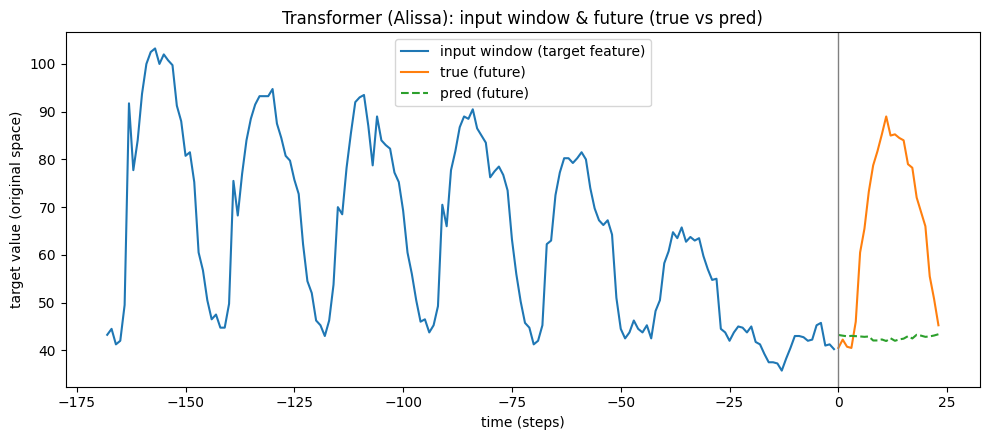

Plotting first sample prediction for Informer...


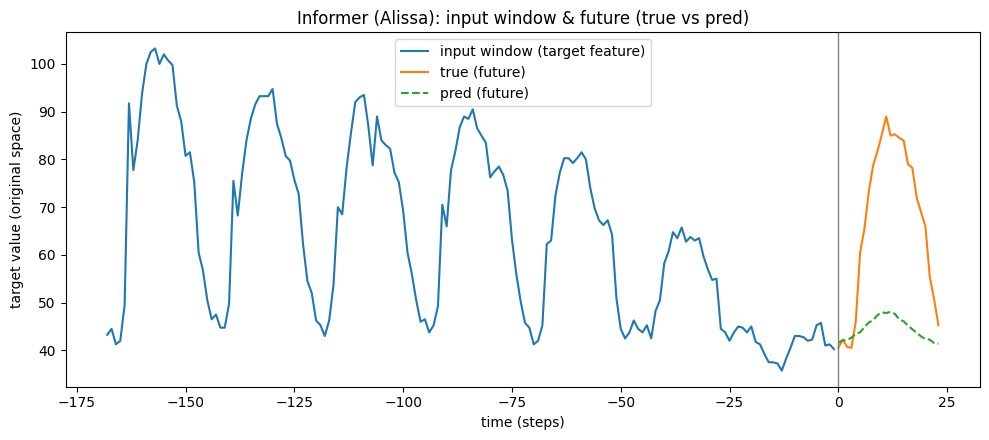

Plotting first sample prediction for Autoformer...


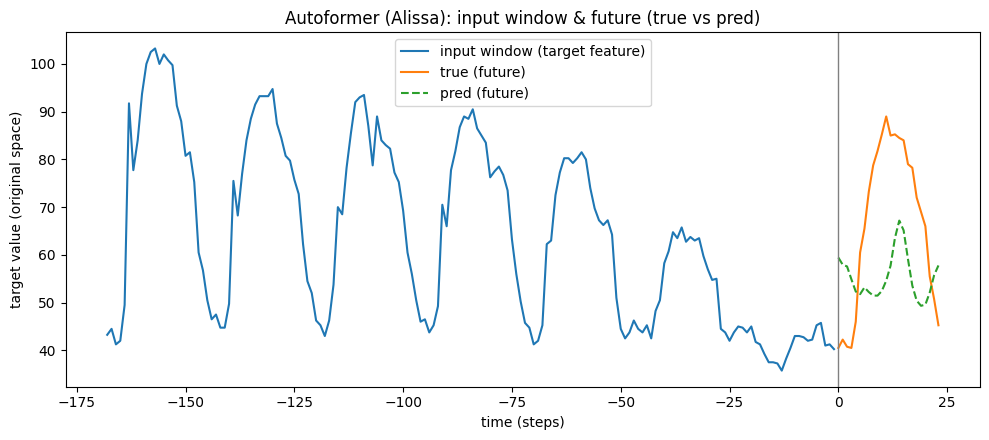

Plotting first sample prediction for FEDformer...


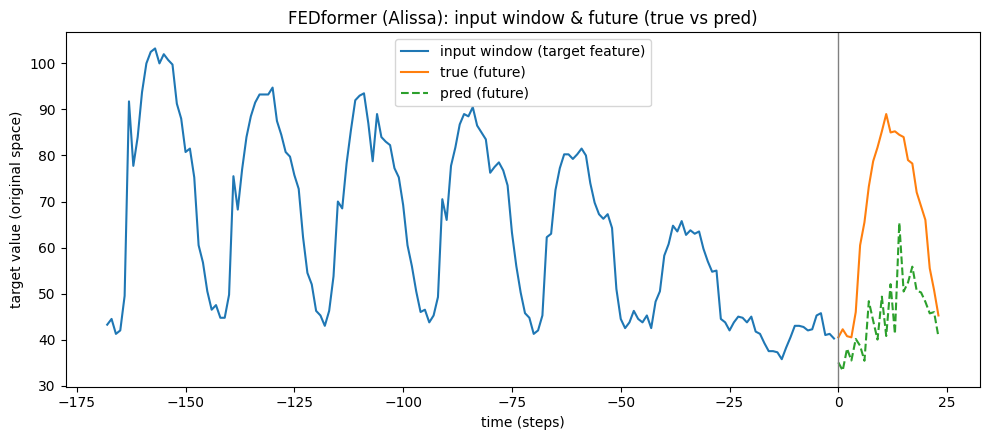

Plotting first sample prediction for PatchTST...


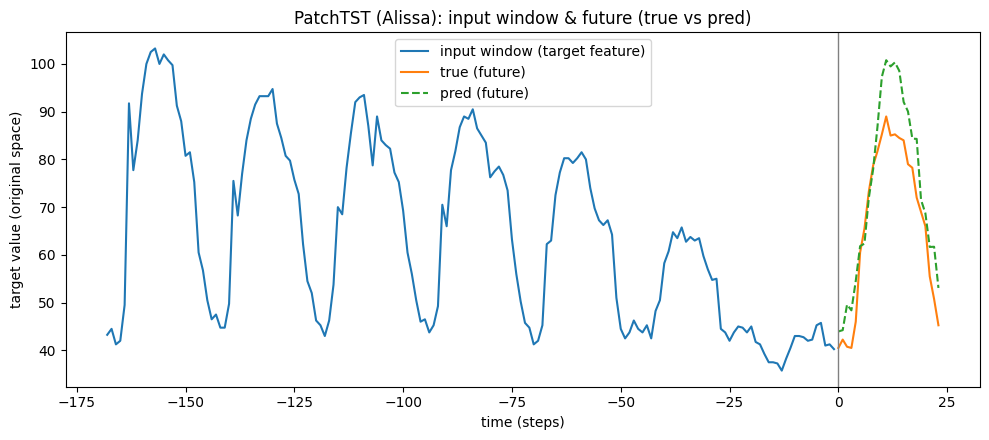

In [ ]:
# long_scalers에서 건물별 스케일러 꺼내기
x_sc_by_bld = long_scalers["X_by_bld"]   # Dict[str, StandardScaler] (입력 전체 피처 기준)
y_sc_by_bld = long_scalers["y_by_bld"]   # Dict[str, StandardScaler] (타깃 시계열 기준)

# 타깃 피처의 X-스케일러가 "동일한 전처리(로그+표준화)"를 따랐고,
# StandardScaler가 피처별로 mean_/scale_를 가지는 구조라면,
# 해당 타깃 피처 인덱스만 뽑아 mean/std를 구성해줘야 함.
tidx = 1  # 예: elec이 X의 몇 번째 피처인지

x_mean_by_bidx = {bid2idx[b]: sc.mean_[tidx]  for b, sc in x_sc_by_bld.items()}
x_std_by_bidx  = {bid2idx[b]: sc.scale_[tidx] for b, sc in x_sc_by_bld.items()}
y_mean_by_bidx = {bid2idx[b]: sc.mean_        for b, sc in y_sc_by_bld.items()}  # (H,) or 스칼라
y_std_by_bidx  = {bid2idx[b]: sc.scale_       for b, sc in y_sc_by_bld.items()}  # (H,) or 스칼라
for name, model in model_list:
    print(f"Plotting first sample prediction for {name}...")
    plot_first_sample_prediction(
        model=model,               # 예: 첫 번째 모델
        loader_te=loader_te,
        # y 복원 (건물별)
        y_log_target=True,
        y_use_by_bidx=True,
        y_mean_by_bidx=y_mean_by_bidx,
        y_std_by_bidx=y_std_by_bidx,
        # X 복원 (건물별, 타깃 피처만)
        x_target_feature_idx=tidx,
        x_log_like_y=True,                    # X의 해당 타깃 피처도 log1p + 표준화로 전처리했다면 True
        x_use_by_bidx=True,
        x_mean_by_bidx=x_mean_by_bidx,
        x_std_by_bidx=x_std_by_bidx,
        # 특정 건물만 첫 샘플을 보고 싶다면(선택)
        only_building="Alissa",
        bid2idx=bid2idx,
        title=f"{name} (Alissa): input window & future (true vs pred)"
    )


In [ ]:
test_layer = long_df[
    (long_df["timestamp"] >= "2017-09-11 00:00:00")
    & (long_df["timestamp"] < "2017-09-19 00:00:00")
    & (long_df["building_name"] == "Alissa")
]

# timestamp, elec 두 열만 선택
test_layer = test_layer[["timestamp", "elec"]]

test_layer


,timestamp,elec
25104,2017-09-11 00:00:00,43.2500
25105,2017-09-11 01:00:00,44.5000
25106,2017-09-11 02:00:00,41.2501
25107,2017-09-11 03:00:00,42.0000
25108,2017-09-11 04:00:00,49.5000
...,...,...
25291,2017-09-18 19:00:00,69.0000
25292,2017-09-18 20:00:00,66.0000
25293,2017-09-18 21:00:00,55.5000
25294,2017-09-18 22:00:00,50.7500


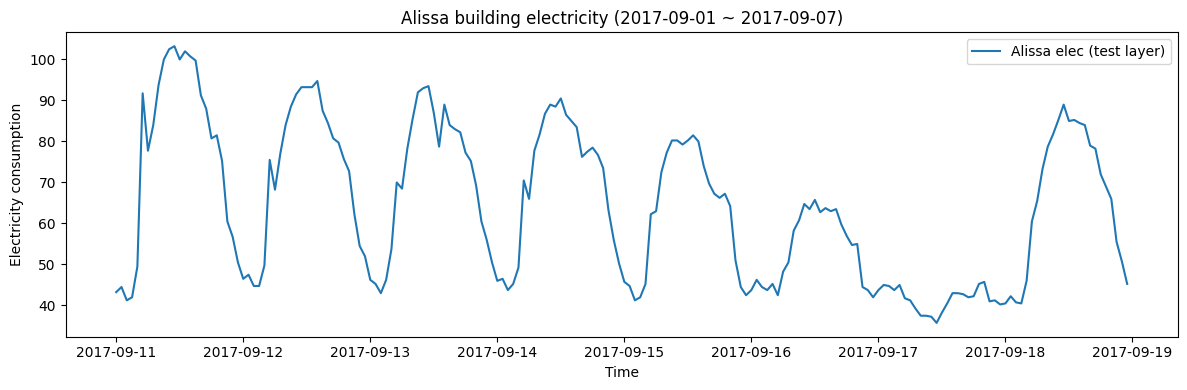

In [ ]:
import matplotlib.pyplot as plt

# timestamp를 datetime으로 변환 (이미 되어 있으면 생략 가능)
test_layer["timestamp"] = pd.to_datetime(test_layer["timestamp"])

plt.figure(figsize=(12, 4))
plt.plot(test_layer["timestamp"], test_layer["elec"], label="Alissa elec (test layer)", color="tab:blue")

plt.title("Alissa building electricity (2017-09-01 ~ 2017-09-07)")
plt.xlabel("Time")
plt.ylabel("Electricity consumption")
plt.legend()
plt.tight_layout()
plt.show()
